# TESS Atlas fit for TOI 537

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 537.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-537.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-537.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-537.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 537

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 537 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

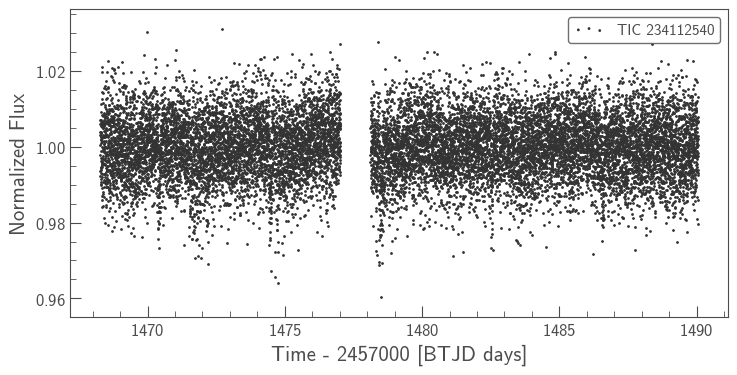

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -55781.663753242996 -> -55734.40111051482


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -52327.957704675355 -> -52115.43597955069


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -52115.43597955069 -> -51963.385911387995


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -51963.385911387995 -> -51963.38081083016


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -51963.38081083016 -> -51963.33113068356


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -51963.33113068356 -> -51963.30483638756


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -51963.30483638756 -> -51963.202288952416


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -51963.202288952416 -> -51963.202288952416


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -51963.202288952416 -> -51963.202288952416


optimizing logp for variables: ['logg_star']
message: Optimization terminated successfully.
logp: -51963.202288952416 -> -51963.202288952416


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -51963.202288952416 -> -51963.20228895241


optimizing logp for variables: ['mean', 'rb_radiusimpact__']
message: Optimization terminated successfully.
logp: -51963.20228895241 -> -51963.20228895241


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']
message: Optimization terminated successfully.
logp: -51963.20228895241 -> -51963.20228895241


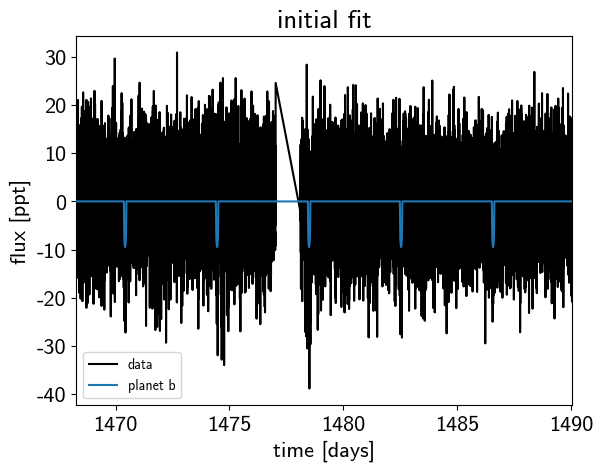

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:05, 18.79draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:09,  9.44draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:12,  7.02draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:14,  6.00draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:15,  5.45draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:13,  6.25draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:18,  4.65draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:02<00:15,  5.32draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:19,  4.32draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:16,  5.06draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:03<00:19,  4.18draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:03<00:16,  4.95draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:19,  4.10draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:16,  4.83draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:04<00:18,  4.07draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:04<00:15,  4.81draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:19,  3.91draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:05<00:18,  3.95draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:18,  3.94draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:06<00:13,  5.14draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:06<00:16,  4.09draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:07<00:16,  4.08draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:07<00:15,  4.06draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:07<00:14,  4.14draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:08<00:14,  4.21draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:08<00:13,  4.26draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:09<00:11,  5.02draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:09<00:13,  4.14draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:09<00:11,  4.65draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:09<00:13,  4.15draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:10<00:12,  4.35draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:10<00:12,  4.25draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:10<00:11,  4.34draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:10<00:12,  4.10draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:10<00:11,  4.41draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:11<00:11,  4.18draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:11<00:10,  4.35draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:11<00:10,  4.24draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:11<00:10,  4.39draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:12<00:08,  5.00draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:12<00:09,  4.43draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:12<00:08,  4.76draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:12<00:10,  3.87draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:13<00:09,  3.88draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:13<00:09,  3.96draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:14<00:08,  4.01draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:14<00:07,  4.26draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:15<00:06,  4.44draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:15<00:08,  3.68draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:15<00:07,  3.64draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:16<00:05,  4.60draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:16<00:06,  3.60draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:17<00:06,  3.69draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:17<00:05,  4.19draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:17<00:05,  3.86draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:17<00:05,  3.66draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:18<00:04,  3.88draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:18<00:05,  3.46draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:18<00:03,  4.25draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:19<00:03,  4.09draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:19<00:03,  4.53draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:19<00:03,  3.94draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:19<00:03,  3.55draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:20<00:02,  3.97draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:20<00:02,  3.52draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:20<00:02,  3.77draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:21<00:02,  3.36draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:21<00:01,  3.72draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:21<00:01,  3.35draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:21<00:01,  3.82draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:22<00:01,  3.25draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:22<00:01,  2.63draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:23<00:00,  2.27draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:24<00:00,  1.97draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:25<00:00,  1.21draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:06, 13.81draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:12,  7.74draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:15,  5.92draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:17,  5.00draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:20,  4.33draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:20,  4.32draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:23,  3.69draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:19,  4.49draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:20,  4.01draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:21,  3.88draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:17,  4.65draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:24,  3.21draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:23,  3.28draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:24,  3.12draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:23,  3.15draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:20,  3.52draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:19,  3.53draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:17,  3.83draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:16,  3.77draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:09<00:16,  3.67draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:10<00:17,  3.44draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:17,  3.31draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:11<00:16,  3.35draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:11<00:13,  4.14draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:19,  2.84draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:12<00:14,  3.59draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:11,  4.43draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:12<00:10,  4.88draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:12<00:10,  4.88draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:13<00:15,  3.10draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:13<00:13,  3.45draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:14<00:17,  2.64draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:14<00:16,  2.79draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:14,  3.01draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:16<00:13,  3.04draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:16<00:12,  3.02draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:17<00:11,  3.12draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:17<00:10,  3.22draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:18<00:09,  3.30draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:18<00:07,  4.37draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:19<00:09,  3.05draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:19<00:07,  3.86draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:19<00:08,  3.28draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:19<00:06,  4.00draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:20<00:06,  3.81draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:20<00:06,  3.66draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:21<00:06,  3.37draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:21<00:06,  3.37draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:21<00:06,  3.05draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:22<00:06,  3.11draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:22<00:05,  3.30draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:22<00:05,  3.30draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:22<00:04,  3.92draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:22<00:03,  4.27draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:23<00:03,  3.64draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:23<00:03,  3.41draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:23<00:03,  3.55draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:24<00:03,  3.40draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:24<00:02,  3.54draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:24<00:02,  3.07draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:25<00:02,  3.48draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:25<00:02,  2.95draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:26<00:01,  3.01draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:26<00:01,  3.42draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:26<00:00,  3.05draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:27<00:00,  2.48draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:28<00:00,  1.37draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:30<00:00,  1.19draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:06,  3.06draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<00:49,  4.06draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:00<00:38,  5.16draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<00:41,  4.73draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<00:37,  5.27draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:01<00:39,  4.97draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:01<00:28,  6.59draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:01<00:22,  8.22draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:02<00:25,  7.39draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:02<00:25,  7.30draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:02<00:22,  8.25draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:02<00:17,  9.99draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:03<00:26,  6.72draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:03<00:28,  6.06draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:04<00:39,  4.42draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:04<00:35,  4.85draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:04<00:35,  4.86draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:04<00:29,  5.72draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:05<00:36,  4.67draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:05<00:27,  5.94draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:05<00:43,  3.81draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:06<00:35,  4.51draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:06<00:33,  4.86draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:06<00:28,  5.53draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:06<00:23,  6.66draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:06<00:28,  5.51draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:07<00:25,  5.97draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:07<00:30,  5.02draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:07<00:22,  6.62draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:08<00:25,  5.79draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:08<00:21,  6.70draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:08<00:22,  6.53draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:08<00:27,  5.17draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:08<00:22,  6.24draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:09<00:17,  8.00draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:09<00:18,  7.53draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:09<00:13,  9.65draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:09<00:14,  9.05draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:10<00:17,  7.21draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:10<00:16,  7.84draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:10<00:15,  8.00draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:11<00:15,  7.83draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:11<00:22,  5.43draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:11<00:19,  6.07draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:11<00:17,  6.89draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:11<00:13,  8.35draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:12<00:12,  9.39draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:12<00:14,  7.78draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:12<00:12,  8.86draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:12<00:12,  8.59draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:13<00:10, 10.02draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:13<00:10,  9.73draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:13<00:11,  8.99draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:13<00:12,  8.07draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:14<00:13,  7.28draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:14<00:20,  4.77draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:14<00:17,  5.56draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:14<00:16,  5.79draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:14<00:16,  5.74draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:15<00:16,  5.66draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:15<00:15,  5.94draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:15<00:14,  6.21draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:15<00:14,  6.01draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:15<00:11,  7.25draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:16<00:09,  8.48draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:16<00:07, 10.77draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:16<00:06, 12.49draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:16<00:05, 14.26draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:16<00:06, 11.32draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:17<00:09,  7.27draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:17<00:07,  9.14draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:17<00:07,  8.33draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:17<00:07,  8.88draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:17<00:05, 10.49draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:18<00:05, 10.90draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:18<00:05, 10.20draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:18<00:07,  7.22draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:19<00:09,  6.03draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:19<00:08,  6.25draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:19<00:10,  4.65draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:20<00:10,  4.82draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:20<00:09,  5.27draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:20<00:08,  5.61draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:20<00:10,  4.26draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:21<00:10,  4.10draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:21<00:09,  4.67draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:21<00:09,  4.41draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:22<00:08,  4.71draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:22<00:05,  6.20draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:22<00:05,  6.41draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:22<00:04,  7.01draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:23<00:04,  6.96draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:23<00:05,  5.89draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:23<00:03,  7.11draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:23<00:03,  7.79draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:23<00:02,  8.82draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:24<00:02,  8.83draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:24<00:02,  8.32draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:24<00:01,  9.79draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:25<00:01,  7.44draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:25<00:01,  7.66draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:25<00:01,  7.59draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:25<00:01,  5.27draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:25<00:01,  6.87draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:26<00:00,  5.56draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:26<00:01,  3.21draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:27<00:00,  3.24draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:27<00:00,  2.66draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:28<00:00,  2.21draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:29<00:00,  1.79draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:10, 37.29draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:11, 34.59draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:11, 32.99draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:00<00:11, 34.81draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:00<00:10, 38.14draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:00<00:09, 38.59draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:00<00:09, 38.12draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:00<00:09, 39.79draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:01<00:08, 42.59draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:01<00:07, 46.57draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:01<00:08, 41.70draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:01<00:08, 40.11draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:01<00:08, 39.53draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:01<00:08, 42.02draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:01<00:08, 39.12draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:02<00:11, 29.12draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:02<00:15, 21.26draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:02<00:12, 25.22draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:02<00:16, 18.65draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:03<00:17, 17.93draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:03<00:15, 19.39draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:03<00:13, 23.30draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:03<00:18, 15.99draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:03<00:17, 17.44draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:03<00:14, 19.65draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:03<00:12, 22.60draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:04<00:10, 25.94draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:04<00:10, 27.84draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:04<00:10, 26.32draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:04<00:10, 25.40draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:04<00:11, 23.75draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:04<00:09, 27.02draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:04<00:08, 30.74draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:05<00:07, 31.94draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:05<00:07, 32.84draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:05<00:08, 30.57draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:05<00:08, 29.88draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:05<00:07, 30.58draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:05<00:07, 32.16draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:05<00:07, 32.43draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:05<00:06, 37.18draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:06<00:05, 41.74draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:06<00:05, 42.23draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:06<00:04, 43.80draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:06<00:04, 41.90draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:06<00:04, 42.40draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:06<00:04, 40.04draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:06<00:05, 34.78draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:06<00:04, 38.21draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:07<00:04, 42.81draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:07<00:03, 44.83draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:07<00:04, 37.65draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:07<00:04, 32.58draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:07<00:04, 33.46draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:07<00:04, 35.09draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:08<00:05, 27.68draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:09<00:17,  8.41draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:10<00:22,  6.32draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:10<00:26,  5.14draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:11<00:29,  4.65draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:11<00:31,  4.30draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:12<00:40,  3.27draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:12<00:38,  3.40draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:12<00:34,  3.75draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:13<00:37,  3.42draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:13<00:32,  3.88draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:13<00:36,  3.51draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:13<00:30,  4.11draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:14<00:30,  4.06draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:14<00:26,  4.70draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:14<00:27,  4.49draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:14<00:23,  5.18draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:15<00:24,  4.86draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:15<00:20,  5.58draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:15<00:18,  6.17draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:15<00:15,  7.14draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:15<00:13,  8.27draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:16<00:11,  9.53draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:16<00:09, 11.65draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:16<00:07, 13.75draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:16<00:05, 17.09draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:16<00:04, 20.52draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:16<00:03, 23.24draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [00:16<00:03, 28.22draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:16<00:02, 31.44draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:16<00:02, 31.20draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:17<00:02, 32.90draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:17<00:02, 33.60draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:17<00:03, 20.33draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [00:17<00:04, 13.70draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:18<00:04, 14.33draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:18<00:03, 14.66draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:18<00:03, 16.01draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [00:18<00:02, 17.83draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [00:18<00:02, 20.60draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:18<00:01, 22.19draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:19<00:01, 21.53draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:19<00:01, 22.02draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:19<00:01, 24.68draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:19<00:00, 28.43draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:19<00:00, 28.69draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:19<00:00, 24.85draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:20<00:00, 16.48draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:20<00:00, 16.18draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:20<00:00, 17.45draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:20<00:00, 18.69draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:20<00:00, 19.31draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:20<00:00, 19.40draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<00:17, 46.57draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:18, 42.50draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:00<00:18, 42.88draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:17, 44.95draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:00<00:21, 35.92draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:00<00:22, 34.97draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:00<00:26, 29.09draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:01<00:37, 20.41draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:01<00:34, 22.25draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:01<00:36, 20.88draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:01<00:44, 17.01draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:01<00:39, 19.36draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:01<00:34, 21.62draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:02<00:34, 21.80draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:02<00:31, 23.61draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:02<00:29, 25.18draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:02<00:25, 28.99draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:02<00:26, 27.21draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:02<00:30, 24.36draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:02<00:28, 25.59draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:02<00:27, 26.81draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:03<00:22, 32.40draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:03<00:19, 36.16draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:03<00:18, 38.24draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:03<00:17, 39.69draws/s]

Sampling 2 chains:  14%|█▎        | 110/804 [00:03<00:16, 42.30draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:03<00:16, 40.86draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:03<00:16, 41.47draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:03<00:15, 42.94draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:04<00:20, 32.51draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:04<00:27, 24.06draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:04<00:31, 20.90draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:04<00:31, 20.77draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:05<00:38, 16.96draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:05<00:36, 17.83draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:05<00:34, 19.17draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:05<00:34, 18.95draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:05<00:35, 18.09draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:05<00:31, 20.27draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:05<00:27, 23.39draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:06<00:24, 26.22draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:06<00:23, 27.23draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:06<00:21, 29.50draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:06<00:31, 19.94draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:07<01:05,  9.56draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:08<01:51,  5.57draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:08<02:15,  4.55draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:09<02:38,  3.88draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:09<02:20,  4.38draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:10<03:23,  3.01draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:10<03:24,  2.99draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:11<03:18,  3.07draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:11<02:39,  3.82draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:11<03:15,  3.11draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:12<02:35,  3.91draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:12<03:13,  3.13draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:13<03:14,  3.10draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:13<03:06,  3.22draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:14<02:51,  3.50draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:14<03:03,  3.26draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:14<02:49,  3.53draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:15<03:13,  3.09draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:15<02:42,  3.67draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:15<02:55,  3.38draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:16<03:04,  3.23draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:16<03:04,  3.21draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:16<03:08,  3.15draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:16<03:00,  3.27draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:17<03:27,  2.85draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:17<02:52,  3.41draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:17<02:29,  3.94draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:18<02:40,  3.66draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:18<02:16,  4.28draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:18<02:04,  4.69draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:18<02:30,  3.89draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:18<01:59,  4.87draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:19<02:17,  4.23draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:19<02:18,  4.18draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:19<01:55,  4.98draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:19<01:46,  5.42draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:19<01:39,  5.76draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:20<01:15,  7.54draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:20<01:02,  9.14draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:20<00:50, 11.33draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:20<00:40, 13.91draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:20<00:34, 16.13draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:20<00:32, 17.33draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:20<00:31, 17.75draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:21<00:33, 16.34draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [00:21<00:33, 16.24draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:21<00:33, 16.31draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:21<00:30, 17.82draws/s]

Sampling 2 chains:  32%|███▏      | 261/804 [00:21<00:31, 17.42draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:21<00:28, 18.65draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:21<00:30, 17.80draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:21<00:29, 18.05draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:22<00:27, 19.61draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:22<00:29, 18.18draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:22<00:30, 17.05draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:22<00:40, 13.11draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:22<00:34, 15.16draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:22<00:32, 16.15draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:23<00:33, 15.71draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:23<00:28, 18.09draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:23<00:29, 17.63draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:23<00:27, 18.73draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:23<00:24, 20.70draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [00:23<00:23, 21.59draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:23<00:21, 23.47draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [00:23<00:19, 24.96draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:24<00:20, 23.82draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:24<00:20, 23.58draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:24<00:19, 24.85draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:24<00:18, 25.66draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:24<00:22, 21.39draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:24<00:21, 22.18draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:24<00:23, 20.18draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:25<00:21, 22.25draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:25<00:22, 21.14draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:25<00:20, 22.46draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:25<00:20, 22.56draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:25<00:19, 23.97draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:25<00:17, 26.27draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:25<00:16, 28.01draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:25<00:17, 25.94draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:26<00:18, 23.61draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:26<00:19, 22.82draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:26<00:18, 23.20draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:26<00:20, 21.50draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:26<00:22, 19.43draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:27<00:28, 15.18draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:27<00:29, 14.69draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:27<00:33, 12.74draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [00:27<00:31, 13.51draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [00:27<00:25, 16.46draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:27<00:23, 18.01draws/s]

Sampling 2 chains:  49%|████▊     | 390/804 [00:27<00:20, 19.87draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:27<00:19, 21.61draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:28<00:17, 23.49draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:28<00:16, 24.64draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:28<00:14, 27.55draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:28<00:13, 29.51draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:28<00:11, 33.05draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:28<00:11, 33.93draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:28<00:10, 35.49draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:28<00:09, 38.90draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:29<00:09, 40.46draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:29<00:08, 41.70draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:29<00:07, 47.18draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:29<00:07, 44.77draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:29<00:07, 44.97draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:29<00:07, 47.12draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:29<00:08, 41.95draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:29<00:09, 35.81draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:30<00:08, 38.16draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:30<00:07, 40.20draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:30<00:06, 45.22draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [00:30<00:06, 46.07draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [00:30<00:06, 48.60draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:30<00:05, 49.72draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [00:30<00:05, 49.74draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:30<00:05, 50.72draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:31<00:05, 49.42draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:31<00:05, 50.09draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [00:31<00:05, 49.46draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:31<00:05, 47.60draws/s]

Sampling 2 chains:  68%|██████▊   | 549/804 [00:31<00:05, 47.85draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:31<00:04, 50.43draws/s]

Sampling 2 chains:  70%|██████▉   | 561/804 [00:31<00:04, 49.57draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:31<00:05, 44.55draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:32<00:05, 38.71draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:32<00:06, 36.90draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:32<00:08, 26.43draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:32<00:09, 22.03draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [00:32<00:10, 21.45draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:32<00:09, 22.78draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:33<00:08, 24.45draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:33<00:08, 23.20draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:33<00:08, 24.13draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:33<00:07, 25.44draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:33<00:08, 23.45draws/s]

Sampling 2 chains:  76%|███████▌  | 610/804 [00:33<00:07, 26.02draws/s]

Sampling 2 chains:  76%|███████▌  | 613/804 [00:33<00:07, 26.24draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [00:33<00:07, 24.01draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:34<00:07, 25.60draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:34<00:06, 26.87draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [00:34<00:05, 29.47draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:34<00:05, 28.63draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:34<00:05, 28.61draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:34<00:07, 22.01draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:35<00:08, 18.41draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:35<00:07, 20.28draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [00:35<00:06, 23.23draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [00:35<00:06, 22.58draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [00:35<00:06, 22.64draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:35<00:06, 23.70draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:35<00:05, 27.51draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:35<00:05, 24.49draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:36<00:05, 26.05draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:36<00:06, 21.64draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [00:36<00:05, 21.80draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:36<00:05, 22.15draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:36<00:05, 22.98draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:36<00:04, 23.94draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [00:36<00:04, 23.02draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [00:37<00:04, 22.82draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:37<00:04, 23.20draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:37<00:04, 23.76draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [00:37<00:04, 25.32draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:37<00:04, 24.77draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [00:37<00:04, 23.69draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [00:38<00:05, 17.80draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [00:38<00:05, 17.06draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:38<00:04, 17.79draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:38<00:04, 17.99draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:38<00:04, 19.26draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [00:38<00:03, 20.32draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [00:38<00:03, 20.98draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [00:38<00:03, 23.95draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:39<00:02, 23.86draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:39<00:02, 26.02draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [00:39<00:03, 20.07draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [00:39<00:03, 17.80draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [00:39<00:03, 17.58draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [00:39<00:02, 19.03draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:40<00:02, 21.22draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [00:40<00:02, 23.11draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:40<00:01, 24.73draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [00:40<00:01, 24.96draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:40<00:01, 27.29draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [00:40<00:01, 27.52draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [00:40<00:01, 17.20draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:41<00:01, 18.51draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [00:41<00:01, 17.72draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [00:41<00:01, 18.09draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [00:41<00:01, 18.24draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [00:41<00:00, 18.28draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [00:41<00:00, 17.49draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [00:41<00:00, 17.95draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:42<00:00, 17.33draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:42<00:00, 15.68draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:42<00:00, 12.48draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:42<00:00, 12.41draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [00:42<00:00, 13.27draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:42<00:00, 18.75draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<07:27,  9.83draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<05:40, 12.92draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<04:47, 15.28draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:00<03:56, 18.54draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:00<03:28, 21.03draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:00<03:04, 23.81draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:00<02:45, 26.48draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:00<02:27, 29.57draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:01<02:21, 30.98draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:01<02:41, 27.03draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:01<02:21, 30.72draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:01<02:21, 30.87draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:01<02:08, 33.85draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:01<02:23, 30.35draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:02<03:11, 22.70draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:02<03:07, 23.17draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:02<03:25, 21.07draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:02<02:58, 24.31draws/s]

Sampling 2 chains:   2%|▏         | 76/4404 [00:02<03:13, 22.42draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:02<03:12, 22.47draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:03<03:46, 19.10draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:03<04:00, 17.98draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:03<04:11, 17.20draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:03<03:22, 21.29draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:03<03:48, 18.84draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:03<03:46, 19.02draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:03<03:56, 18.21draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:04<03:55, 18.25draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:04<03:32, 20.17draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:04<03:03, 23.40draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:04<02:52, 24.94draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:04<02:32, 28.03draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:04<02:57, 24.15draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:04<03:02, 23.45draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:05<03:06, 22.94draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:05<05:18, 13.43draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:05<06:56, 10.26draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:05<06:27, 11.02draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:06<09:08,  7.79draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:06<11:29,  6.19draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:07<10:37,  6.69draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:07<09:41,  7.33draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:07<08:36,  8.25draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:07<08:47,  8.08draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:07<08:38,  8.21draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:07<07:05, 10.00draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:07<06:20, 11.19draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:07<05:34, 12.72draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:08<04:46, 14.85draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:08<04:07, 17.17draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:08<03:49, 18.45draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:08<03:45, 18.75draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:08<04:04, 17.31draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:08<04:23, 16.08draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:09<04:17, 16.45draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:09<04:15, 16.54draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:09<04:17, 16.42draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:09<04:09, 16.91draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:09<04:07, 17.03draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:09<03:52, 18.14draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:09<05:12, 13.48draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:10<05:35, 12.58draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:10<04:55, 14.23draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:10<04:08, 16.94draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:10<03:40, 19.09draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:10<03:40, 19.06draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:10<03:49, 18.32draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:11<03:59, 17.53draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:11<03:38, 19.19draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:11<03:36, 19.34draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:11<03:24, 20.50draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:11<02:56, 23.64draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:11<02:42, 25.64draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:11<02:45, 25.19draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:11<02:51, 24.32draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:11<02:32, 27.26draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:12<02:41, 25.84draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:12<02:46, 25.05draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:12<02:46, 24.94draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:12<02:59, 23.17draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:12<02:44, 25.25draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [00:12<02:38, 26.19draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:12<02:25, 28.51draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:13<02:33, 26.94draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:13<03:10, 21.76draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:13<03:40, 18.74draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:13<03:21, 20.46draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:13<03:40, 18.69draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:13<03:39, 18.81draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:14<03:24, 20.13draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:14<03:04, 22.30draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:14<02:54, 23.64draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:14<02:42, 25.34draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:14<02:45, 24.82draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:14<02:41, 25.47draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:14<02:37, 26.05draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:14<02:59, 22.90draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:15<02:56, 23.16draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:15<02:48, 24.30draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:15<02:44, 24.80draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:15<02:43, 25.07draws/s]

Sampling 2 chains:   7%|▋         | 320/4404 [00:15<02:35, 26.34draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:15<02:30, 27.04draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:15<02:34, 26.45draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:15<02:36, 26.04draws/s]

Sampling 2 chains:   8%|▊         | 332/4404 [00:16<02:53, 23.45draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:16<02:49, 24.00draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:16<03:11, 21.28draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:16<03:33, 19.06draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:16<03:55, 17.21draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:16<03:39, 18.52draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:17<03:26, 19.67draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:17<03:02, 22.23draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:17<02:57, 22.78draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:17<02:59, 22.54draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:17<03:17, 20.50draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:17<03:06, 21.64draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:17<03:30, 19.13draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:18<04:02, 16.64draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:18<04:02, 16.63draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [00:18<03:54, 17.21draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:18<03:36, 18.59draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [00:18<03:51, 17.38draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:18<04:01, 16.67draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:18<03:53, 17.21draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [00:19<04:04, 16.45draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:19<03:41, 18.10draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:19<03:51, 17.34draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:19<03:57, 16.89draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:19<04:05, 16.30draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:19<04:08, 16.12draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:19<04:11, 15.94draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:20<04:51, 13.72draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:20<04:36, 14.45draws/s]

Sampling 2 chains:   9%|▉         | 408/4404 [00:20<04:16, 15.61draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:20<04:03, 16.43draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:20<03:55, 16.94draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:20<03:17, 20.22draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:20<03:17, 20.22draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:20<03:39, 18.13draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:21<04:09, 15.95draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:21<04:14, 15.62draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:21<04:00, 16.50draws/s]

Sampling 2 chains:  10%|▉         | 431/4404 [00:21<04:43, 14.04draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:21<04:16, 15.50draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:21<03:53, 16.97draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:22<04:00, 16.47draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:22<03:43, 17.76draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:22<03:58, 16.59draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:22<03:40, 17.98draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [00:22<03:15, 20.20draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:22<03:12, 20.51draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:22<02:57, 22.18draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:23<03:25, 19.24draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [00:23<03:16, 20.07draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:23<03:21, 19.56draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [00:23<03:39, 17.90draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:23<03:37, 18.06draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:23<03:22, 19.42draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:24<04:04, 16.09draws/s]

Sampling 2 chains:  11%|█         | 479/4404 [00:24<04:46, 13.68draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:24<04:19, 15.11draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:24<05:08, 12.72draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:24<04:39, 14.04draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:24<04:07, 15.85draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:24<03:50, 17.00draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:25<03:40, 17.71draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:25<04:59, 13.03draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:25<06:04, 10.72draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:25<05:18, 12.27draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:25<05:46, 11.28draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:26<05:00, 12.98draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [00:26<04:38, 13.99draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:26<05:48, 11.17draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:26<05:46, 11.23draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [00:26<05:20, 12.14draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:26<05:00, 12.95draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:26<04:42, 13.77draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:27<04:01, 16.08draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:27<03:39, 17.68draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:27<03:16, 19.76draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:27<03:15, 19.84draws/s]

Sampling 2 chains:  12%|█▏        | 530/4404 [00:27<03:24, 18.92draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:27<03:38, 17.72draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [00:27<03:35, 17.97draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:28<03:16, 19.71draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [00:28<03:26, 18.73draws/s]

Sampling 2 chains:  12%|█▏        | 544/4404 [00:28<03:27, 18.61draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:28<03:24, 18.90draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:28<04:04, 15.80draws/s]

Sampling 2 chains:  13%|█▎        | 551/4404 [00:28<03:33, 18.01draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:28<03:19, 19.29draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:29<03:23, 18.86draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:29<03:34, 17.90draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:29<03:08, 20.36draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:29<03:17, 19.39draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:29<03:01, 21.14draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [00:29<03:34, 17.85draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:30<03:25, 18.62draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:30<03:30, 18.19draws/s]

Sampling 2 chains:  13%|█▎        | 581/4404 [00:30<03:15, 19.53draws/s]

Sampling 2 chains:  13%|█▎        | 586/4404 [00:30<02:47, 22.82draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:30<03:02, 20.90draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [00:30<03:06, 20.45draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:30<03:02, 20.84draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:31<02:59, 21.20draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:31<03:53, 16.29draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [00:31<03:53, 16.25draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:31<04:11, 15.08draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [00:31<04:13, 14.96draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [00:31<03:49, 16.50draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:32<03:27, 18.30draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [00:32<03:21, 18.82draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [00:32<03:14, 19.47draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:32<03:01, 20.85draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:32<03:11, 19.71draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:32<03:17, 19.09draws/s]

Sampling 2 chains:  14%|█▍        | 631/4404 [00:32<03:17, 19.07draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [00:33<03:23, 18.55draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [00:33<03:07, 20.08draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [00:33<02:54, 21.60draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [00:33<02:40, 23.48draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:33<02:48, 22.26draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [00:33<03:01, 20.72draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:33<03:04, 20.31draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:34<03:55, 15.95draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [00:34<04:00, 15.57draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:34<04:06, 15.17draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:34<03:55, 15.90draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [00:34<04:27, 14.01draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:34<05:00, 12.44draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [00:35<04:21, 14.31draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [00:35<04:52, 12.77draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:35<05:28, 11.37draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:35<05:28, 11.36draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [00:35<04:47, 12.98draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:35<04:30, 13.80draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:35<04:17, 14.46draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [00:36<04:52, 12.71draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [00:36<04:49, 12.84draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:36<04:26, 13.94draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [00:36<04:20, 14.28draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:36<05:18, 11.66draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [00:37<05:42, 10.85draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [00:37<05:35, 11.05draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [00:37<04:36, 13.39draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [00:37<04:01, 15.34draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:37<03:38, 16.92draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:37<03:14, 19.03draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:37<03:16, 18.81draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [00:38<03:11, 19.32draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:38<02:57, 20.83draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:38<02:54, 21.06draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:38<02:44, 22.37draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:38<02:36, 23.50draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [00:38<02:31, 24.27draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:38<02:49, 21.64draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:39<02:46, 22.11draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [00:39<02:49, 21.60draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:39<02:47, 21.94draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [00:39<02:55, 20.81draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [00:39<02:53, 21.11draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [00:39<02:48, 21.68draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [00:39<03:08, 19.36draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [00:40<03:20, 18.18draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [00:40<03:13, 18.87draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:40<03:16, 18.51draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [00:40<03:23, 17.90draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [00:40<03:26, 17.61draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:40<03:28, 17.46draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [00:40<03:02, 19.91draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [00:40<03:03, 19.75draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [00:41<03:01, 19.97draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [00:41<03:02, 19.90draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [00:41<02:59, 20.19draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [00:41<03:01, 19.99draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [00:41<02:48, 21.53draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [00:41<02:37, 22.97draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:41<02:38, 22.73draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [00:41<02:27, 24.44draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [00:42<02:51, 20.98draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [00:42<02:44, 21.96draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [00:42<04:39, 12.86draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [00:42<05:02, 11.89draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [00:43<04:27, 13.42draws/s]

Sampling 2 chains:  18%|█▊        | 811/4404 [00:43<04:27, 13.42draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [00:43<04:02, 14.84draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [00:43<03:44, 15.98draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [00:43<03:32, 16.91draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [00:43<03:20, 17.87draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [00:43<02:58, 20.06draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [00:44<03:21, 17.77draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [00:44<03:43, 15.99draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [00:44<03:26, 17.30draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [00:44<03:09, 18.87draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:44<02:48, 21.16draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [00:44<02:32, 23.42draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [00:44<02:29, 23.82draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [00:44<02:31, 23.55draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [00:45<02:52, 20.65draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [00:45<02:50, 20.77draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [00:45<02:45, 21.41draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [00:45<02:49, 20.93draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [00:45<03:31, 16.71draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [00:45<03:26, 17.13draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [00:46<04:01, 14.63draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [00:46<03:29, 16.83draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [00:46<03:32, 16.59draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:46<03:23, 17.36draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [00:46<03:09, 18.63draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [00:46<03:14, 18.13draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [00:46<03:05, 19.02draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [00:46<02:42, 21.64draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [00:47<02:38, 22.19draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [00:47<02:34, 22.67draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [00:47<02:33, 22.83draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [00:47<02:22, 24.52draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [00:47<02:21, 24.70draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [00:47<02:34, 22.59draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [00:47<02:24, 24.14draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [00:48<02:09, 26.99draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [00:48<01:58, 29.38draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [00:48<02:23, 24.29draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [00:48<02:53, 20.08draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [00:48<03:10, 18.24draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [00:48<03:08, 18.43draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [00:49<03:53, 14.84draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [00:49<03:53, 14.88draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [00:49<03:51, 14.95draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [00:49<03:41, 15.63draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [00:49<03:33, 16.22draws/s]

Sampling 2 chains:  21%|██▏       | 944/4404 [00:49<03:38, 15.83draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [00:50<04:05, 14.11draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [00:50<03:38, 15.81draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [00:50<03:19, 17.28draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [00:50<02:47, 20.57draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [00:50<02:44, 20.94draws/s]

Sampling 2 chains:  22%|██▏       | 962/4404 [00:50<02:45, 20.74draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [00:50<02:36, 21.97draws/s]

Sampling 2 chains:  22%|██▏       | 968/4404 [00:50<02:34, 22.18draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [00:51<02:30, 22.85draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [00:51<02:33, 22.36draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [00:51<02:30, 22.79draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [00:51<02:31, 22.61draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [00:51<02:25, 23.51draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [00:51<02:20, 24.40draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [00:51<02:18, 24.64draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [00:51<02:06, 26.91draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:52<02:13, 25.51draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [00:52<02:20, 24.25draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:52<02:26, 23.28draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [00:52<02:39, 21.28draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [00:52<02:30, 22.49draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [00:52<02:29, 22.76draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:52<02:23, 23.59draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [00:53<02:42, 20.85draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [00:53<03:21, 16.76draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [00:53<03:44, 15.08draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [00:53<03:43, 15.14draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [00:53<03:50, 14.66draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [00:53<03:39, 15.36draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [00:54<03:50, 14.64draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [00:54<03:33, 15.80draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [00:54<03:40, 15.30draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [00:54<03:17, 17.03draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [00:54<02:52, 19.50draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [00:54<02:58, 18.83draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [00:54<02:49, 19.77draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [00:55<02:47, 19.96draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [00:55<02:40, 20.90draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [00:55<02:40, 20.87draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [00:55<02:29, 22.38draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [00:55<02:58, 18.77draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [00:55<03:23, 16.43draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [00:56<03:46, 14.76draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:56<03:15, 17.02draws/s]

Sampling 2 chains:  24%|██▍       | 1073/4404 [00:56<03:10, 17.45draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [00:56<03:17, 16.85draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [00:56<03:19, 16.67draws/s]

Sampling 2 chains:  25%|██▍       | 1080/4404 [00:56<03:15, 17.01draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [00:56<03:18, 16.77draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [00:56<03:06, 17.79draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [00:57<03:22, 16.34draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [00:57<02:57, 18.70draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [00:57<02:43, 20.23draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [00:57<02:47, 19.74draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [00:57<02:56, 18.69draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [00:57<03:09, 17.39draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [00:57<03:03, 18.01draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [00:58<02:53, 19.04draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [00:58<03:07, 17.61draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [00:58<03:16, 16.79draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [00:58<03:19, 16.51draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [00:58<03:26, 15.89draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [00:58<03:08, 17.45draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [00:59<03:51, 14.17draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [00:59<03:50, 14.23draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [00:59<03:47, 14.41draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [00:59<03:43, 14.67draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [00:59<03:34, 15.26draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [00:59<03:08, 17.38draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [00:59<03:33, 15.31draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [01:00<03:19, 16.37draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [01:00<03:42, 14.66draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [01:00<03:39, 14.87draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [01:00<03:09, 17.17draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [01:00<02:46, 19.61draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [01:00<03:09, 17.15draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [01:00<03:14, 16.70draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [01:01<03:36, 15.01draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [01:01<03:16, 16.49draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [01:01<03:08, 17.25draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [01:01<02:53, 18.64draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [01:01<02:36, 20.66draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [01:01<03:24, 15.84draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [01:02<04:59, 10.79draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [01:02<05:31,  9.75draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [01:02<07:23,  7.29draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [01:03<07:59,  6.74draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [01:03<12:30,  4.30draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [01:04<15:57,  3.37draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [01:04<14:54,  3.60draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [01:05<17:53,  3.00draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [01:05<14:13,  3.77draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [01:05<13:56,  3.85draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [01:05<16:22,  3.28draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [01:06<14:34,  3.68draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [01:06<16:06,  3.33draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [01:07<14:17,  3.75draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [01:07<11:37,  4.61draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [01:07<10:06,  5.29draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [01:07<08:00,  6.67draws/s]

Sampling 2 chains:  27%|██▋       | 1197/4404 [01:07<09:46,  5.47draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [01:08<16:25,  3.25draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [01:08<13:13,  4.04draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [01:09<19:03,  2.80draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [01:09<15:26,  3.46draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [01:09<18:23,  2.90draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [01:10<16:23,  3.25draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [01:10<22:35,  2.36draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [01:10<17:51,  2.98draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [01:11<16:05,  3.31draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [01:11<22:29,  2.37draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [01:12<19:30,  2.73draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [01:12<22:25,  2.37draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [01:13<21:23,  2.49draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [01:13<21:35,  2.46draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [01:13<17:58,  2.96draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [01:13<15:39,  3.39draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [01:14<16:52,  3.15draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [01:14<14:47,  3.59draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [01:14<13:40,  3.88draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [01:15<12:15,  4.33draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [01:15<11:12,  4.73draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [01:15<13:21,  3.97draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [01:15<12:25,  4.27draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [01:16<12:04,  4.39draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [01:16<10:06,  5.24draws/s]

Sampling 2 chains:  28%|██▊       | 1229/4404 [01:16<09:51,  5.37draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [01:16<09:29,  5.57draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [01:17<09:17,  5.69draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [01:17<09:17,  5.69draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [01:17<08:14,  6.41draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [01:17<11:30,  4.59draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [01:18<12:04,  4.37draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [01:18<10:13,  5.16draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [01:18<10:27,  5.04draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [01:18<10:20,  5.10draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [01:19<10:02,  5.25draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [01:19<09:37,  5.47draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [01:19<13:37,  3.87draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [01:19<11:32,  4.56draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [01:20<10:40,  4.93draws/s]

Sampling 2 chains:  28%|██▊       | 1247/4404 [01:20<12:57,  4.06draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [01:20<11:23,  4.62draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [01:20<11:28,  4.59draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [01:20<10:45,  4.88draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [01:21<10:22,  5.06draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [01:21<09:54,  5.30draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [01:21<08:30,  6.17draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [01:21<08:53,  5.90draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [01:21<09:13,  5.69draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [01:22<09:23,  5.58draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [01:22<08:04,  6.49draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [01:22<06:55,  7.56draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [01:22<05:52,  8.91draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [01:22<05:22,  9.74draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [01:22<04:38, 11.24draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [01:23<04:45, 10.98draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [01:23<04:27, 11.72draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [01:23<04:20, 12.02draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [01:23<03:44, 13.91draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [01:23<03:16, 15.91draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [01:23<03:02, 17.12draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [01:23<02:46, 18.78draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [01:24<02:33, 20.34draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [01:24<02:31, 20.48draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [01:24<02:24, 21.46draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [01:24<02:41, 19.22draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [01:24<02:45, 18.79draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [01:24<02:59, 17.29draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [01:24<02:52, 17.97draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [01:25<02:35, 19.86draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [01:25<02:42, 19.06draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [01:25<02:46, 18.60draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [01:25<02:56, 17.47draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [01:25<02:54, 17.70draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [01:25<02:34, 19.89draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [01:26<02:41, 19.01draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [01:26<03:01, 16.92draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [01:26<03:26, 14.85draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [01:26<03:26, 14.85draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [01:26<03:00, 17.02draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [01:26<02:54, 17.53draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [01:26<02:39, 19.22draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [01:26<02:37, 19.49draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [01:27<02:37, 19.41draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [01:27<02:33, 19.97draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [01:27<02:12, 23.04draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [01:27<02:21, 21.57draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [01:27<02:21, 21.51draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [01:27<02:15, 22.44draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [01:27<02:21, 21.49draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [01:28<02:16, 22.32draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [01:28<02:12, 22.88draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [01:28<02:33, 19.79draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [01:28<02:59, 16.87draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [01:28<02:56, 17.17draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [01:28<03:01, 16.69draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [01:28<02:53, 17.43draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [01:29<02:36, 19.24draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [01:29<02:30, 20.01draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [01:29<02:24, 20.83draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [01:29<02:39, 18.86draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [01:29<02:38, 18.96draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [01:29<02:44, 18.29draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [01:29<02:40, 18.74draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [01:30<02:28, 20.14draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [01:30<02:41, 18.57draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [01:30<02:38, 18.83draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [01:30<02:34, 19.29draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [01:30<02:31, 19.66draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [01:30<02:19, 21.38draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [01:30<02:23, 20.77draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [01:31<02:23, 20.71draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [01:31<02:25, 20.49draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [01:31<02:24, 20.58draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [01:31<02:23, 20.75draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [01:31<02:03, 23.91draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [01:31<02:16, 21.72draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [01:31<02:07, 23.11draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [01:32<02:11, 22.55draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [01:32<02:19, 21.13draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [01:32<02:10, 22.58draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [01:32<02:07, 23.05draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [01:32<03:01, 16.24draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [01:33<04:10, 11.75draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [01:33<05:10,  9.46draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [01:33<05:51,  8.36draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [01:33<05:28,  8.93draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [01:34<04:32, 10.77draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [01:34<04:30, 10.84draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [01:34<04:36, 10.57draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [01:34<04:11, 11.65draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [01:34<03:33, 13.67draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [01:34<03:03, 15.92draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [01:34<03:02, 16.02draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [01:35<03:10, 15.29draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [01:35<03:12, 15.13draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [01:35<02:47, 17.34draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [01:35<02:31, 19.22draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [01:35<02:17, 21.09draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [01:35<02:09, 22.37draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [01:35<02:16, 21.20draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [01:36<02:13, 21.68draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [01:36<02:21, 20.37draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [01:36<02:25, 19.91draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [01:36<02:37, 18.35draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [01:36<02:27, 19.52draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [01:36<02:28, 19.39draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [01:36<02:41, 17.85draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [01:37<02:44, 17.43draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [01:37<02:32, 18.88draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [01:37<02:15, 21.22draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [01:37<02:27, 19.43draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [01:37<02:23, 19.89draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [01:37<02:21, 20.25draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [01:37<02:15, 21.01draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [01:38<02:23, 19.89draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [01:38<02:16, 20.90draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [01:38<02:11, 21.63draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [01:38<02:08, 22.14draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [01:38<02:12, 21.41draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [01:38<02:31, 18.69draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [01:38<02:16, 20.77draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [01:39<02:16, 20.75draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [01:39<02:14, 20.98draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [01:39<02:29, 18.90draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [01:39<02:31, 18.59draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [01:39<02:29, 18.91draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [01:39<02:13, 21.11draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [01:39<01:54, 24.59draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [01:40<02:04, 22.54draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [01:40<02:25, 19.24draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [01:40<02:41, 17.34draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [01:40<02:27, 18.94draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [01:40<02:42, 17.25draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [01:40<03:04, 15.13draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [01:41<03:31, 13.22draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [01:41<02:56, 15.78draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [01:41<02:37, 17.71draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [01:41<03:02, 15.24draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [01:41<03:06, 14.93draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [01:41<02:58, 15.54draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [01:42<02:50, 16.30draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [01:42<02:23, 19.28draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [01:42<02:26, 18.90draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [01:42<02:31, 18.30draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [01:42<02:18, 20.02draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [01:42<02:05, 22.08draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [01:42<02:03, 22.25draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [01:43<02:02, 22.47draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [01:43<02:04, 22.15draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [01:43<02:42, 16.94draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [01:43<02:24, 19.05draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [01:43<02:21, 19.35draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [01:43<02:33, 17.88draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [01:44<02:19, 19.59draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [01:44<02:24, 18.90draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [01:44<02:15, 20.19draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [01:44<02:26, 18.59draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [01:44<02:16, 19.90draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [01:44<02:04, 21.80draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [01:44<02:02, 22.23draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [01:45<02:02, 22.13draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [01:45<01:46, 25.35draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [01:45<01:53, 23.85draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [01:45<01:54, 23.58draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [01:45<01:56, 23.27draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [01:45<01:55, 23.29draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [01:45<01:54, 23.59draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [01:45<01:49, 24.55draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [01:46<01:39, 27.05draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [01:46<02:19, 19.24draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [01:46<02:51, 15.60draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [01:46<02:51, 15.62draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [01:47<03:27, 12.87draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [01:47<03:11, 13.93draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [01:47<03:51, 11.55draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [01:47<03:48, 11.66draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [01:47<03:54, 11.39draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [01:47<03:30, 12.68draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [01:48<03:23, 13.09draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [01:48<03:28, 12.77draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [01:48<03:02, 14.56draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [01:48<03:13, 13.69draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [01:48<02:57, 14.92draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [01:48<02:46, 15.95draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [01:49<03:31, 12.51draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [01:49<03:23, 13.02draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [01:49<03:03, 14.43draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [01:49<03:08, 14.06draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [01:49<03:38, 12.07draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [01:49<03:18, 13.31draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [01:49<03:20, 13.14draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [01:50<03:02, 14.43draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [01:50<03:09, 13.90draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [01:50<02:56, 14.94draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [01:50<02:41, 16.28draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [01:50<02:28, 17.71draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [01:50<02:21, 18.57draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [01:50<02:13, 19.61draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [01:51<02:06, 20.59draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [01:51<01:50, 23.62draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [01:51<01:45, 24.62draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [01:51<01:38, 26.37draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [01:51<01:33, 27.79draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [01:51<01:39, 25.97draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [01:51<01:42, 25.38draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [01:51<01:43, 24.92draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [01:52<01:58, 21.75draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [01:52<02:00, 21.49draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [01:52<01:51, 23.24draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [01:52<01:48, 23.78draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [01:52<01:42, 25.01draws/s]

Sampling 2 chains:  42%|████▏     | 1832/4404 [01:52<01:45, 24.39draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [01:52<01:44, 24.68draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [01:53<01:59, 21.53draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [01:53<01:56, 21.91draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [01:53<01:48, 23.59draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [01:53<01:47, 23.70draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [01:53<02:02, 20.86draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [01:53<02:03, 20.73draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [01:53<02:12, 19.21draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [01:54<02:21, 17.98draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [01:54<02:27, 17.20draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [01:54<02:37, 16.15draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [01:54<02:25, 17.43draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [01:54<02:19, 18.12draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [01:54<02:33, 16.49draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [01:54<02:31, 16.68draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [01:55<02:28, 17.03draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [01:55<02:54, 14.51draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [01:55<03:27, 12.15draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [01:55<03:16, 12.87draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [01:55<03:08, 13.40draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [01:55<02:59, 14.01draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [01:55<02:56, 14.26draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [01:56<02:45, 15.20draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [01:56<02:30, 16.67draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [01:56<02:13, 18.87draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [01:56<02:25, 17.20draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [01:56<02:03, 20.26draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [01:56<02:30, 16.66draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [01:57<02:37, 15.89draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [01:57<03:29, 11.92draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [01:57<02:59, 13.89draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [01:57<02:45, 15.09draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [01:57<02:28, 16.73draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [01:57<02:29, 16.61draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [01:57<02:17, 18.04draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [01:58<02:10, 19.05draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [01:58<02:05, 19.74draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [01:58<01:49, 22.54draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [01:58<02:03, 19.98draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [01:58<02:08, 19.24draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [01:58<02:33, 16.02draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [01:59<02:43, 15.05draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [01:59<03:02, 13.49draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [01:59<03:02, 13.48draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [01:59<03:07, 13.09draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [01:59<03:00, 13.60draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [01:59<02:39, 15.38draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [02:00<02:24, 16.94draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [02:00<02:14, 18.22draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [02:00<02:06, 19.25draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [02:00<01:55, 21.06draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [02:00<01:47, 22.55draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [02:00<01:49, 22.14draws/s]

Sampling 2 chains:  45%|████▍     | 1977/4404 [02:00<01:49, 22.10draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [02:00<01:45, 23.00draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [02:01<01:39, 24.43draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [02:01<01:39, 24.42draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [02:01<01:42, 23.66draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [02:01<01:39, 24.31draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [02:01<01:43, 23.27draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [02:01<01:44, 23.06draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [02:01<01:44, 22.90draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [02:02<01:45, 22.83draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [02:02<01:44, 22.84draws/s]

Sampling 2 chains:  46%|████▌     | 2010/4404 [02:02<01:55, 20.78draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [02:02<01:52, 21.33draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [02:02<01:44, 22.75draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [02:02<01:49, 21.69draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [02:02<01:58, 20.16draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [02:02<01:49, 21.69draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [02:03<01:58, 20.06draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [02:03<02:26, 16.24draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [02:03<02:30, 15.78draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [02:03<02:34, 15.38draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [02:03<02:33, 15.40draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [02:04<02:30, 15.71draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [02:04<02:56, 13.38draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [02:04<02:46, 14.18draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [02:04<02:39, 14.83draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [02:04<02:24, 16.32draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [02:04<02:17, 17.16draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [02:04<01:54, 20.50draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [02:05<02:25, 16.17draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [02:05<02:37, 14.85draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [02:05<02:47, 13.94draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [02:05<03:11, 12.20draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [02:05<02:56, 13.23draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [02:05<02:45, 14.07draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [02:05<02:24, 16.18draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [02:06<02:09, 18.06draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [02:06<01:58, 19.66draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [02:06<01:50, 20.96draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [02:06<01:45, 21.93draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [02:06<01:42, 22.66draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [02:06<01:32, 24.91draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [02:06<01:37, 23.65draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [02:06<01:38, 23.44draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [02:07<01:36, 23.77draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [02:07<01:32, 24.98draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [02:07<01:32, 24.77draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [02:07<01:29, 25.77draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [02:07<01:31, 25.14draws/s]

Sampling 2 chains:  48%|████▊     | 2115/4404 [02:07<01:43, 22.21draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [02:07<02:00, 18.93draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [02:08<01:57, 19.49draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [02:08<01:50, 20.57draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [02:08<01:41, 22.40draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [02:08<01:35, 23.75draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [02:08<01:35, 23.66draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [02:08<01:33, 24.20draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [02:08<01:34, 23.86draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [02:08<01:31, 24.65draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [02:09<01:26, 26.02draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [02:09<01:23, 27.13draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [02:09<01:51, 20.12draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [02:09<02:13, 16.83draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [02:09<02:38, 14.19draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [02:10<02:51, 13.07draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [02:10<03:01, 12.34draws/s]

Sampling 2 chains:  49%|████▉     | 2164/4404 [02:10<02:43, 13.67draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [02:10<02:35, 14.38draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [02:10<02:43, 13.69draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [02:10<02:27, 15.11draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [02:10<02:24, 15.42draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [02:11<02:08, 17.33draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [02:11<01:57, 18.98draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [02:11<01:44, 21.22draws/s]

Sampling 2 chains:  50%|████▉     | 2184/4404 [02:11<01:40, 22.04draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [02:11<01:37, 22.72draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [02:11<01:35, 23.24draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [02:11<01:33, 23.55draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [02:11<01:32, 23.81draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [02:11<01:31, 24.14draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [02:12<01:30, 24.24draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [02:12<01:33, 23.54draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [02:12<01:32, 23.65draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [02:12<01:35, 23.04draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [02:12<01:30, 24.08draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [02:12<01:45, 20.71draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [02:12<01:43, 21.16draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [02:13<01:39, 22.02draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [02:13<01:32, 23.61draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [02:13<01:39, 21.75draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [02:13<01:43, 21.05draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [02:13<01:44, 20.80draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [02:13<01:44, 20.66draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [02:13<01:30, 23.89draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [02:14<01:33, 23.08draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [02:14<01:33, 23.04draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [02:14<01:40, 21.44draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [02:14<02:18, 15.50draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [02:14<02:29, 14.34draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [02:14<02:17, 15.59draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [02:15<02:07, 16.78draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [02:15<01:59, 17.85draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [02:15<02:03, 17.34draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [02:15<02:03, 17.25draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [02:15<02:01, 17.55draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [02:15<01:52, 18.90draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [02:15<01:41, 20.86draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [02:16<01:33, 22.63draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [02:16<01:36, 21.88draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [02:16<01:38, 21.50draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [02:16<01:32, 22.81draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [02:16<01:35, 22.07draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [02:16<01:40, 20.89draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [02:16<01:38, 21.44draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [02:16<01:37, 21.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [02:17<01:35, 22.00draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [02:17<01:27, 23.94draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [02:17<01:37, 21.48draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [02:17<01:31, 22.74draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [02:17<01:29, 23.26draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [02:17<01:33, 22.21draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [02:17<01:40, 20.74draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [02:18<01:42, 20.17draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [02:18<01:45, 19.58draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [02:18<01:46, 19.54draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [02:18<01:55, 17.96draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [02:18<02:07, 16.25draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [02:18<02:05, 16.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [02:19<02:08, 16.05draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [02:19<02:11, 15.72draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [02:19<02:04, 16.55draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [02:19<02:07, 16.16draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [02:19<02:02, 16.80draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [02:19<01:57, 17.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [02:19<01:46, 19.15draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [02:19<01:38, 20.72draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [02:19<01:40, 20.28draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [02:20<01:32, 22.16draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [02:20<01:26, 23.48draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [02:20<01:25, 23.83draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [02:20<01:34, 21.46draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [02:20<01:42, 19.75draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [02:20<01:37, 20.76draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [02:20<01:39, 20.38draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [02:21<01:41, 19.87draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [02:21<01:43, 19.54draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [02:21<01:45, 19.12draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [02:21<01:46, 18.83draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [02:21<01:53, 17.71draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [02:21<01:55, 17.37draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [02:21<01:36, 20.74draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [02:22<01:31, 21.94draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [02:22<01:42, 19.44draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [02:22<01:37, 20.39draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [02:30<27:23,  1.21draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [02:37<53:04,  1.60s/draws]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [02:43<1:07:19,  2.04s/draws]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [02:45<1:13:41,  2.23s/draws]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [02:48<1:16:59,  2.33s/draws]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [02:51<1:19:10,  2.40s/draws]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [02:53<1:22:00,  2.48s/draws]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [02:56<1:24:22,  2.56s/draws]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [02:59<1:27:54,  2.67s/draws]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [03:02<1:27:54,  2.67s/draws]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [03:04<1:27:48,  2.66s/draws]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [03:07<1:27:45,  2.66s/draws]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [03:10<1:27:57,  2.67s/draws]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [03:12<1:27:48,  2.67s/draws]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [03:15<1:27:49,  2.67s/draws]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [03:18<1:29:15,  2.72s/draws]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [03:21<1:32:43,  2.82s/draws]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [03:24<1:34:01,  2.86s/draws]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [03:27<1:39:06,  3.02s/draws]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [03:30<1:38:17,  3.00s/draws]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [03:33<1:38:18,  3.00s/draws]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [03:37<1:44:04,  3.18s/draws]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [03:40<1:46:23,  3.25s/draws]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [03:43<1:45:26,  3.22s/draws]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [03:46<1:40:13,  3.06s/draws]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [03:49<1:37:45,  2.99s/draws]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [03:51<1:34:54,  2.90s/draws]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [03:55<1:36:39,  2.96s/draws]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [03:58<1:39:14,  3.04s/draws]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [04:00<1:35:11,  2.92s/draws]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [04:03<1:31:38,  2.81s/draws]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [04:05<1:26:29,  2.65s/draws]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [04:08<1:23:54,  2.58s/draws]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [04:10<1:23:43,  2.57s/draws]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [04:13<1:22:55,  2.55s/draws]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [04:15<1:21:49,  2.52s/draws]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [04:18<1:21:09,  2.50s/draws]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [04:20<1:20:40,  2.48s/draws]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [04:23<1:21:56,  2.52s/draws]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [04:25<1:22:07,  2.53s/draws]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [04:28<1:20:25,  2.48s/draws]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [04:30<1:19:52,  2.46s/draws]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [04:32<1:18:48,  2.43s/draws]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [04:35<1:17:39,  2.40s/draws]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [04:37<1:20:52,  2.50s/draws]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [04:40<1:19:31,  2.46s/draws]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [04:42<1:20:22,  2.48s/draws]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [04:45<1:19:03,  2.45s/draws]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [04:47<1:18:51,  2.44s/draws]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [04:50<1:18:31,  2.43s/draws]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [04:52<1:18:08,  2.42s/draws]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [04:54<1:18:16,  2.43s/draws]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [04:57<1:22:04,  2.55s/draws]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [05:00<1:20:13,  2.49s/draws]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [05:02<1:24:10,  2.61s/draws]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [05:05<1:24:25,  2.62s/draws]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [05:08<1:29:28,  2.78s/draws]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [05:11<1:25:55,  2.67s/draws]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [05:14<1:28:18,  2.75s/draws]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [05:16<1:27:57,  2.74s/draws]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [05:19<1:28:59,  2.77s/draws]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [05:22<1:31:51,  2.86s/draws]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [05:25<1:31:50,  2.86s/draws]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [05:28<1:34:27,  2.95s/draws]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [05:31<1:35:55,  2.99s/draws]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [05:34<1:35:35,  2.98s/draws]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [05:38<1:39:05,  3.09s/draws]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [05:41<1:40:32,  3.14s/draws]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [05:44<1:41:58,  3.19s/draws]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [05:47<1:39:53,  3.12s/draws]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [05:50<1:37:28,  3.05s/draws]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [05:54<1:42:57,  3.22s/draws]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [05:57<1:41:27,  3.18s/draws]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [06:00<1:41:42,  3.19s/draws]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [06:03<1:43:10,  3.24s/draws]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [06:06<1:42:03,  3.20s/draws]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [06:10<1:41:53,  3.20s/draws]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [06:12<1:36:51,  3.04s/draws]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [06:15<1:34:46,  2.98s/draws]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [06:19<1:38:42,  3.10s/draws]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [06:22<1:41:51,  3.21s/draws]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [06:25<1:39:23,  3.13s/draws]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [06:28<1:37:36,  3.07s/draws]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [06:31<1:34:42,  2.98s/draws]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [06:33<1:32:59,  2.93s/draws]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [06:37<1:34:42,  2.99s/draws]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [06:39<1:33:29,  2.95s/draws]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [06:42<1:32:19,  2.92s/draws]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [06:45<1:31:31,  2.89s/draws]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [06:48<1:29:06,  2.82s/draws]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [06:50<1:27:14,  2.76s/draws]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [06:53<1:26:06,  2.72s/draws]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [06:56<1:25:13,  2.70s/draws]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [06:59<1:27:30,  2.77s/draws]

Sampling 2 chains:  57%|█████▋    | 2511/4404 [07:01<1:27:33,  2.78s/draws]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [07:04<1:27:56,  2.79s/draws]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [07:08<1:33:03,  2.95s/draws]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [07:11<1:33:46,  2.98s/draws]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [07:14<1:38:37,  3.13s/draws]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [07:17<1:41:13,  3.22s/draws]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [07:21<1:39:23,  3.16s/draws]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [07:24<1:45:58,  3.37s/draws]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [07:28<1:49:58,  3.50s/draws]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [07:32<1:49:32,  3.49s/draws]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [07:36<1:53:53,  3.63s/draws]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [07:39<1:53:17,  3.61s/draws]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [07:42<1:46:31,  3.40s/draws]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [07:45<1:42:01,  3.26s/draws]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [07:48<1:38:55,  3.16s/draws]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [07:51<1:37:45,  3.12s/draws]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [07:54<1:38:23,  3.15s/draws]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [07:57<1:38:46,  3.16s/draws]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [08:00<1:38:31,  3.15s/draws]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [08:04<1:42:38,  3.29s/draws]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [08:08<1:47:27,  3.44s/draws]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [08:11<1:42:17,  3.28s/draws]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [08:14<1:40:45,  3.23s/draws]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [08:17<1:40:04,  3.21s/draws]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [08:20<1:41:20,  3.25s/draws]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [08:24<1:40:26,  3.23s/draws]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [08:27<1:46:45,  3.43s/draws]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [08:31<1:49:44,  3.53s/draws]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [08:34<1:45:56,  3.41s/draws]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [08:37<1:40:39,  3.24s/draws]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [08:40<1:36:53,  3.12s/draws]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [08:43<1:36:46,  3.12s/draws]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [08:46<1:36:45,  3.12s/draws]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [08:50<1:42:19,  3.30s/draws]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [08:53<1:41:49,  3.29s/draws]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [08:57<1:44:34,  3.38s/draws]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [09:00<1:39:33,  3.22s/draws]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [09:03<1:36:35,  3.12s/draws]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [09:06<1:34:42,  3.06s/draws]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [09:08<1:30:27,  2.93s/draws]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [09:11<1:30:16,  2.92s/draws]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [09:14<1:30:00,  2.92s/draws]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [09:17<1:29:31,  2.90s/draws]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [09:19<1:27:14,  2.83s/draws]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [09:23<1:29:43,  2.91s/draws]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [09:25<1:28:38,  2.88s/draws]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [09:28<1:29:06,  2.89s/draws]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [09:31<1:28:55,  2.89s/draws]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [09:34<1:28:36,  2.88s/draws]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [09:37<1:29:07,  2.90s/draws]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [09:40<1:30:12,  2.94s/draws]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [09:43<1:26:21,  2.81s/draws]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [09:45<1:26:24,  2.82s/draws]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [09:48<1:28:24,  2.88s/draws]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [09:51<1:29:17,  2.91s/draws]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [09:55<1:33:02,  3.04s/draws]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [09:58<1:31:09,  2.98s/draws]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [10:00<1:29:49,  2.94s/draws]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [10:03<1:29:47,  2.94s/draws]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [10:07<1:34:58,  3.11s/draws]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [10:10<1:34:31,  3.09s/draws]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [10:13<1:36:25,  3.16s/draws]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [10:16<1:34:41,  3.10s/draws]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [10:19<1:36:03,  3.15s/draws]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [10:22<1:32:35,  3.04s/draws]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [10:25<1:29:47,  2.95s/draws]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [10:28<1:30:36,  2.98s/draws]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [10:32<1:39:18,  3.26s/draws]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [10:35<1:39:52,  3.28s/draws]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [10:38<1:38:25,  3.24s/draws]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [10:41<1:35:32,  3.14s/draws]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [10:44<1:34:39,  3.12s/draws]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [10:47<1:33:04,  3.07s/draws]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [10:51<1:38:53,  3.26s/draws]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [10:54<1:37:17,  3.21s/draws]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [10:57<1:35:29,  3.15s/draws]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [11:00<1:35:13,  3.14s/draws]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [11:03<1:33:41,  3.10s/draws]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [11:06<1:31:46,  3.03s/draws]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [11:09<1:29:06,  2.95s/draws]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [11:12<1:26:40,  2.87s/draws]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [11:14<1:24:31,  2.80s/draws]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [11:17<1:23:05,  2.75s/draws]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [11:20<1:22:04,  2.72s/draws]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [11:22<1:21:24,  2.70s/draws]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [11:25<1:22:50,  2.75s/draws]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [11:28<1:21:35,  2.71s/draws]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [11:30<1:21:45,  2.72s/draws]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [11:33<1:24:56,  2.82s/draws]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [11:37<1:27:45,  2.92s/draws]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [11:40<1:36:11,  3.20s/draws]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [11:43<1:34:14,  3.14s/draws]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [11:46<1:32:42,  3.09s/draws]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [11:49<1:31:32,  3.05s/draws]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [11:52<1:30:10,  3.01s/draws]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [11:56<1:34:05,  3.14s/draws]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [11:59<1:39:16,  3.31s/draws]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [12:02<1:36:27,  3.22s/draws]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [12:06<1:35:16,  3.18s/draws]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [12:09<1:36:33,  3.23s/draws]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [12:12<1:36:22,  3.23s/draws]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [12:15<1:35:30,  3.20s/draws]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [12:19<1:37:40,  3.27s/draws]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [12:23<1:42:46,  3.45s/draws]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [12:26<1:43:05,  3.46s/draws]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [12:30<1:43:56,  3.49s/draws]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [12:33<1:44:42,  3.52s/draws]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [12:37<1:45:32,  3.55s/draws]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [12:40<1:43:39,  3.48s/draws]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [12:44<1:47:14,  3.61s/draws]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [12:48<1:51:42,  3.76s/draws]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [12:51<1:45:34,  3.55s/draws]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [12:55<1:44:11,  3.51s/draws]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [12:57<1:38:11,  3.31s/draws]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [13:00<1:33:59,  3.17s/draws]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [13:03<1:29:49,  3.03s/draws]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [13:06<1:28:33,  2.99s/draws]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [13:09<1:25:23,  2.89s/draws]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [13:11<1:23:50,  2.83s/draws]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [13:14<1:26:09,  2.91s/draws]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [13:17<1:24:01,  2.84s/draws]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [13:20<1:23:15,  2.82s/draws]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [13:23<1:23:30,  2.83s/draws]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [13:25<1:22:38,  2.80s/draws]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [13:28<1:21:36,  2.77s/draws]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [13:31<1:20:51,  2.74s/draws]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [13:34<1:23:14,  2.83s/draws]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [13:37<1:22:53,  2.82s/draws]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [13:39<1:23:17,  2.83s/draws]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [13:42<1:22:41,  2.81s/draws]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [13:45<1:21:22,  2.77s/draws]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [13:48<1:20:11,  2.73s/draws]

Sampling 2 chains:  60%|██████    | 2643/4404 [13:50<1:19:18,  2.70s/draws]

Sampling 2 chains:  60%|██████    | 2644/4404 [13:53<1:18:36,  2.68s/draws]

Sampling 2 chains:  60%|██████    | 2645/4404 [13:55<1:17:44,  2.65s/draws]

Sampling 2 chains:  60%|██████    | 2646/4404 [13:58<1:17:04,  2.63s/draws]

Sampling 2 chains:  60%|██████    | 2647/4404 [14:00<1:16:08,  2.60s/draws]

Sampling 2 chains:  60%|██████    | 2648/4404 [14:03<1:15:14,  2.57s/draws]

Sampling 2 chains:  60%|██████    | 2649/4404 [14:06<1:17:59,  2.67s/draws]

Sampling 2 chains:  60%|██████    | 2650/4404 [14:09<1:23:44,  2.86s/draws]

Sampling 2 chains:  60%|██████    | 2651/4404 [14:12<1:21:56,  2.80s/draws]

Sampling 2 chains:  60%|██████    | 2652/4404 [14:15<1:21:44,  2.80s/draws]

Sampling 2 chains:  60%|██████    | 2653/4404 [14:17<1:20:33,  2.76s/draws]

Sampling 2 chains:  60%|██████    | 2654/4404 [14:20<1:19:47,  2.74s/draws]

Sampling 2 chains:  60%|██████    | 2655/4404 [14:23<1:19:43,  2.74s/draws]

Sampling 2 chains:  60%|██████    | 2656/4404 [14:25<1:19:15,  2.72s/draws]

Sampling 2 chains:  60%|██████    | 2657/4404 [14:28<1:18:50,  2.71s/draws]

Sampling 2 chains:  60%|██████    | 2658/4404 [14:31<1:19:41,  2.74s/draws]

Sampling 2 chains:  60%|██████    | 2659/4404 [14:34<1:18:48,  2.71s/draws]

Sampling 2 chains:  60%|██████    | 2660/4404 [14:36<1:13:50,  2.54s/draws]

Sampling 2 chains:  60%|██████    | 2661/4404 [14:38<1:14:43,  2.57s/draws]

Sampling 2 chains:  60%|██████    | 2662/4404 [14:41<1:15:21,  2.60s/draws]

Sampling 2 chains:  60%|██████    | 2663/4404 [14:44<1:15:43,  2.61s/draws]

Sampling 2 chains:  60%|██████    | 2664/4404 [14:46<1:15:58,  2.62s/draws]

Sampling 2 chains:  61%|██████    | 2665/4404 [14:48<1:09:27,  2.40s/draws]

Sampling 2 chains:  61%|██████    | 2666/4404 [14:51<1:11:29,  2.47s/draws]

Sampling 2 chains:  61%|██████    | 2667/4404 [14:53<1:12:54,  2.52s/draws]

Sampling 2 chains:  61%|██████    | 2668/4404 [14:56<1:13:51,  2.55s/draws]

Sampling 2 chains:  61%|██████    | 2669/4404 [14:59<1:14:25,  2.57s/draws]

Sampling 2 chains:  61%|██████    | 2670/4404 [15:01<1:14:53,  2.59s/draws]

Sampling 2 chains:  61%|██████    | 2671/4404 [15:04<1:15:13,  2.60s/draws]

Sampling 2 chains:  61%|██████    | 2672/4404 [15:05<1:04:08,  2.22s/draws]

Sampling 2 chains:  61%|██████    | 2673/4404 [15:07<56:06,  1.94s/draws]  

Sampling 2 chains:  61%|██████    | 2674/4404 [15:08<50:34,  1.75s/draws]

Sampling 2 chains:  61%|██████    | 2675/4404 [15:09<46:54,  1.63s/draws]

Sampling 2 chains:  61%|██████    | 2676/4404 [15:11<44:10,  1.53s/draws]

Sampling 2 chains:  61%|██████    | 2677/4404 [15:12<42:29,  1.48s/draws]

Sampling 2 chains:  61%|██████    | 2678/4404 [15:13<41:54,  1.46s/draws]

Sampling 2 chains:  61%|██████    | 2679/4404 [15:14<35:12,  1.22s/draws]

Sampling 2 chains:  61%|██████    | 2680/4404 [15:15<36:25,  1.27s/draws]

Sampling 2 chains:  61%|██████    | 2681/4404 [15:16<31:22,  1.09s/draws]

Sampling 2 chains:  61%|██████    | 2682/4404 [15:17<27:53,  1.03draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [15:17<25:25,  1.13draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [15:18<23:39,  1.21draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [15:19<22:27,  1.28draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [15:19<21:59,  1.30draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [15:20<18:20,  1.56draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [15:21<18:39,  1.53draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [15:21<15:51,  1.80draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [15:21<13:54,  2.06draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [15:21<12:31,  2.28draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [15:22<11:33,  2.47draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [15:22<09:31,  2.99draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [15:22<08:08,  3.50draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [15:22<07:07,  4.00draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [15:22<06:23,  4.46draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [15:23<05:53,  4.83draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [15:23<05:10,  5.50draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [15:23<05:01,  5.65draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [15:23<04:33,  6.21draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [15:23<04:35,  6.17draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [15:24<03:45,  7.53draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [15:24<03:20,  8.48draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [15:24<03:12,  8.80draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [15:24<02:46, 10.17draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [15:24<02:27, 11.43draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [15:24<02:15, 12.49draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [15:25<01:57, 14.35draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [15:25<02:04, 13.56draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [15:25<01:58, 14.19draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [15:25<01:43, 16.16draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [15:25<01:33, 17.89draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [15:25<01:24, 19.72draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [15:26<02:12, 12.57draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [15:26<02:39, 10.44draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [15:26<03:26,  8.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [15:27<03:11,  8.68draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [15:27<03:00,  9.20draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [15:27<02:40, 10.30draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [15:27<02:38, 10.43draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [15:27<02:25, 11.40draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [15:27<02:03, 13.39draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [15:27<01:57, 13.98draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [15:28<02:06, 13.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [15:28<02:00, 13.60draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [15:28<01:58, 13.82draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [15:28<01:46, 15.44draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [15:28<01:40, 16.33draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [15:28<01:36, 16.99draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [15:28<01:28, 18.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [15:29<01:24, 19.39draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [15:29<01:24, 19.31draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [15:29<01:20, 20.14draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [15:29<01:14, 21.71draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [15:29<01:13, 21.98draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [15:29<01:17, 20.94draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [15:29<01:23, 19.40draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [15:29<01:22, 19.47draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [15:30<01:32, 17.39draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [15:30<01:40, 16.05draws/s]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [15:30<01:35, 16.84draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [15:30<01:40, 16.02draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [15:30<01:42, 15.59draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [15:30<01:45, 15.18draws/s]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [15:30<01:47, 14.81draws/s]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [15:31<01:59, 13.33draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [15:31<02:30, 10.56draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [15:31<02:25, 10.89draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [15:31<02:26, 10.85draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [15:32<02:17, 11.50draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [15:32<02:01, 13.06draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [15:32<01:47, 14.73draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [15:32<01:36, 16.36draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [15:32<01:26, 18.25draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [15:32<01:18, 19.96draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [15:32<01:10, 22.16draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [15:32<01:03, 24.52draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [15:33<01:07, 22.97draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [15:33<01:06, 23.55draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [15:33<01:02, 24.82draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [15:33<01:06, 23.41draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [15:33<01:04, 23.89draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [15:33<01:13, 21.08draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [15:33<01:13, 21.07draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [15:34<01:12, 21.26draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [15:34<01:08, 22.47draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [15:34<01:16, 20.02draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [15:34<01:21, 18.71draws/s]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [15:34<01:40, 15.23draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [15:34<01:32, 16.45draws/s]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [15:34<01:27, 17.37draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [15:35<01:30, 16.86draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [15:35<01:45, 14.45draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [15:35<01:34, 16.04draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [15:35<01:28, 17.00draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [15:35<01:29, 16.95draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [15:35<01:19, 19.05draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [15:35<01:10, 21.38draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [15:36<01:12, 20.84draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [15:36<01:11, 20.82draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [15:36<01:16, 19.54draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [15:36<01:20, 18.42draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [15:36<01:13, 20.33draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [15:36<01:19, 18.68draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [15:37<01:40, 14.76draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [15:37<01:30, 16.41draws/s]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [15:37<01:26, 17.16draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [15:37<01:29, 16.47draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [15:37<01:21, 18.09draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [15:37<01:29, 16.43draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [15:37<01:24, 17.45draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [15:38<01:14, 19.60draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [15:38<01:15, 19.45draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [15:38<01:28, 16.54draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [15:38<01:41, 14.40draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [15:39<04:57,  4.90draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [15:40<06:50,  3.54draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [15:40<06:08,  3.94draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [15:40<05:38,  4.29draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [15:41<05:18,  4.55draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [15:41<05:02,  4.79draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [15:41<06:08,  3.93draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [15:41<05:38,  4.27draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [15:42<05:18,  4.54draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [15:42<05:11,  4.64draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [15:42<04:34,  5.25draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [15:42<04:33,  5.27draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [15:42<04:38,  5.17draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [15:43<04:30,  5.34draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [15:43<04:28,  5.37draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [15:43<03:47,  6.32draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [15:43<03:18,  7.24draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [15:43<03:00,  7.93draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [15:44<02:54,  8.22draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [15:44<02:48,  8.47draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [15:44<02:44,  8.67draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [15:44<02:27,  9.66draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [15:44<02:02, 11.66draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [15:44<01:48, 13.08draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [15:44<01:58, 12.04draws/s]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [15:45<02:04, 11.41draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [15:45<01:59, 11.88draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [15:45<01:47, 13.12draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [15:45<01:39, 14.13draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [15:45<01:28, 15.89draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [15:45<01:31, 15.42draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [15:45<01:23, 16.81draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [15:46<01:18, 17.80draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [15:46<01:21, 17.12draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [15:46<01:17, 18.10draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [15:46<01:25, 16.31draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [15:46<01:18, 17.71draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [15:46<01:20, 17.29draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [15:46<01:16, 18.09draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [15:47<01:12, 18.94draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [15:47<01:09, 19.87draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [15:47<01:08, 20.06draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [15:47<01:06, 20.80draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [15:47<01:04, 21.17draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [15:47<01:03, 21.46draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [15:47<00:58, 23.23draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [15:48<01:01, 22.25draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [15:48<01:01, 22.16draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [15:48<01:06, 20.24draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [15:48<01:05, 20.60draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [15:48<01:23, 16.22draws/s]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [15:48<01:25, 15.81draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [15:49<01:17, 17.30draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [15:49<01:13, 18.11draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [15:49<01:12, 18.48draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [15:49<01:05, 20.35draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [15:49<01:04, 20.78draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [15:49<01:03, 20.80draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [15:49<01:02, 21.26draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [15:50<00:58, 22.70draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [15:50<00:55, 23.62draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [15:50<00:53, 24.69draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [15:50<00:57, 22.80draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [15:50<01:05, 20.01draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [15:50<01:01, 21.21draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [15:50<00:57, 22.73draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [15:50<00:58, 22.34draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [15:51<00:58, 22.01draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [15:51<00:57, 22.62draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [15:51<00:57, 22.32draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [15:51<01:13, 17.59draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [15:51<01:10, 18.21draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [15:51<01:07, 19.03draws/s]

Sampling 2 chains:  71%|███████   | 3123/4404 [15:51<01:04, 19.92draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [15:52<01:02, 20.30draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [15:52<00:58, 21.95draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [15:52<00:56, 22.64draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [15:52<00:52, 24.26draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [15:52<00:50, 24.99draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [15:52<00:49, 25.72draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [15:52<00:53, 23.59draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [15:53<00:58, 21.42draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [15:53<01:00, 20.65draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [15:53<00:57, 21.84draws/s]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [15:53<00:59, 20.88draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [15:53<01:01, 20.24draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [15:53<00:59, 20.82draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [15:53<01:01, 20.21draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [15:54<01:05, 18.76draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [15:54<01:12, 17.10draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [15:54<01:16, 16.12draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [15:54<01:12, 16.95draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [15:54<01:16, 16.09draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [15:54<01:18, 15.63draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [15:54<01:13, 16.64draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [15:54<01:16, 16.01draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [15:55<01:19, 15.32draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [15:55<01:22, 14.85draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [15:55<01:23, 14.64draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [15:55<01:17, 15.62draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [15:55<01:11, 16.85draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [15:55<01:09, 17.40draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [15:55<01:12, 16.57draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [15:56<01:09, 17.46draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [15:56<01:10, 17.08draws/s]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [15:56<01:05, 18.34draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [15:56<01:13, 16.40draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [15:56<01:23, 14.39draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [15:56<01:14, 16.07draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [15:56<01:16, 15.59draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [15:57<01:26, 13.69draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [15:57<01:37, 12.23draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [15:57<01:31, 13.00draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [15:57<01:25, 13.76draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [15:57<01:20, 14.62draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [15:57<01:11, 16.53draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [15:57<01:12, 16.18draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [15:58<01:12, 16.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [15:58<01:06, 17.68draws/s]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [15:58<01:01, 18.85draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [15:58<00:58, 19.81draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [15:58<00:59, 19.61draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [15:58<00:57, 20.19draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [15:58<00:56, 20.46draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [15:59<00:53, 21.44draws/s]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [15:59<00:49, 23.02draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [15:59<00:53, 21.48draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [15:59<00:50, 22.45draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [15:59<00:47, 24.05draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [15:59<00:41, 27.37draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [15:59<00:41, 27.15draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [15:59<00:47, 23.88draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [16:00<00:49, 22.73draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [16:00<00:49, 22.71draws/s]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [16:00<00:58, 19.01draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [16:00<00:59, 18.88draws/s]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [16:00<01:01, 18.00draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [16:00<01:00, 18.49draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [16:01<01:02, 17.74draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [16:01<01:07, 16.36draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [16:01<01:10, 15.66draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [16:01<01:05, 16.84draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [16:01<01:10, 15.71draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [16:01<01:06, 16.56draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [16:01<00:59, 18.36draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [16:01<00:55, 19.77draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [16:02<00:56, 19.34draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [16:02<01:00, 18.00draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [16:02<00:56, 19.09draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [16:02<00:54, 19.95draws/s]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [16:02<00:53, 20.18draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [16:02<00:57, 18.56draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [16:03<00:54, 19.68draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [16:03<00:52, 20.30draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [16:03<00:51, 20.57draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [16:03<00:47, 22.21draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [16:03<00:48, 21.93draws/s]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [16:03<00:44, 23.79draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [16:03<00:42, 24.74draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [16:03<00:43, 24.03draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [16:04<00:38, 26.77draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [16:04<00:41, 25.13draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [16:04<00:45, 22.67draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [16:04<00:45, 22.52draws/s]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [16:04<00:48, 21.29draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [16:04<00:45, 22.77draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [16:04<00:47, 21.79draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [16:05<00:48, 21.30draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [16:05<00:48, 21.11draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [16:05<00:46, 21.79draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [16:05<00:45, 22.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [16:05<00:43, 23.30draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [16:05<00:44, 22.83draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [16:05<00:43, 23.04draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [16:06<00:45, 22.20draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [16:06<00:44, 22.27draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [16:06<00:44, 22.48draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [16:06<00:48, 20.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [16:06<00:50, 19.51draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [16:06<00:54, 18.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [16:06<00:50, 19.58draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [16:07<00:58, 16.80draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [16:07<00:54, 18.10draws/s]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [16:07<00:50, 19.41draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [16:07<00:46, 20.85draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [16:07<00:46, 21.05draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [16:07<00:53, 18.17draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [16:08<01:06, 14.44draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [16:08<01:09, 13.84draws/s]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [16:08<01:08, 13.98draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [16:08<01:04, 14.93draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [16:08<01:06, 14.32draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [16:08<01:15, 12.58draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [16:09<01:13, 12.95draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [16:09<01:06, 14.36draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [16:09<00:55, 17.00draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [16:09<01:21, 11.62draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [16:09<01:11, 13.22draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [16:09<01:04, 14.54draws/s]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [16:09<00:55, 16.79draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [16:10<00:58, 16.06draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [16:10<00:54, 17.25draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [16:10<00:49, 18.59draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [16:10<00:49, 18.60draws/s]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [16:10<00:46, 20.06draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [16:10<00:53, 17.11draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [16:11<01:03, 14.54draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [16:11<01:14, 12.36draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [16:11<01:23, 10.92draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [16:11<01:13, 12.42draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [16:11<01:12, 12.63draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [16:11<01:12, 12.49draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [16:12<01:35,  9.54draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [16:12<01:26, 10.41draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [16:12<01:17, 11.61draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [16:12<01:08, 13.07draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [16:12<01:15, 11.82draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [16:12<01:06, 13.37draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [16:13<01:11, 12.45draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [16:13<01:05, 13.60draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [16:13<00:59, 14.85draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [16:13<00:54, 16.28draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [16:13<00:52, 16.94draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [16:13<00:47, 18.44draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [16:13<00:47, 18.56draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [16:13<00:43, 20.10draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [16:14<00:42, 20.73draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [16:14<00:40, 21.63draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [16:14<00:37, 23.32draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [16:14<00:39, 22.08draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [16:14<00:39, 22.03draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [16:14<00:39, 21.94draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [16:14<00:38, 22.48draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [16:15<00:37, 22.51draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [16:15<00:36, 23.06draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [16:15<00:36, 23.53draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [16:15<00:37, 22.71draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [16:15<00:38, 22.07draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [16:15<00:37, 22.06draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [16:15<00:49, 17.02draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [16:16<00:55, 15.10draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [16:16<00:53, 15.43draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [16:16<00:50, 16.53draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [16:16<00:46, 17.68draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [16:16<00:47, 17.34draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [16:16<00:43, 18.93draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [16:16<00:39, 20.59draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [16:17<00:36, 22.31draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [16:17<00:38, 21.06draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [16:17<00:36, 22.33draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [16:17<00:36, 22.14draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [16:17<00:34, 23.52draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [16:17<00:35, 22.33draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [16:17<00:36, 21.49draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [16:18<00:36, 21.48draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [16:18<00:36, 21.63draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [16:18<00:35, 22.45draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [16:18<00:32, 24.17draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [16:18<00:33, 23.49draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [16:18<00:34, 22.50draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [16:18<00:34, 22.40draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [16:18<00:32, 23.43draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [16:19<00:31, 24.14draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [16:19<00:33, 22.92draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [16:19<00:35, 21.39draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [16:19<00:32, 23.34draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [16:19<00:33, 22.67draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [16:19<00:31, 23.77draws/s]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [16:19<00:30, 24.87draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [16:20<00:33, 22.10draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [16:20<00:44, 16.66draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [16:20<01:09, 10.60draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [16:20<01:28,  8.33draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [16:21<01:46,  6.93draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [16:22<02:22,  5.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [16:22<03:28,  3.53draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [16:23<05:52,  2.08draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [16:24<07:35,  1.61draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [16:25<09:20,  1.30draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [16:27<13:44,  1.13s/draws]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [16:29<16:50,  1.39s/draws]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [16:30<15:44,  1.30s/draws]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [16:33<20:27,  1.69s/draws]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [16:36<26:19,  2.18s/draws]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [16:38<25:20,  2.10s/draws]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [16:39<23:13,  1.92s/draws]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [16:42<25:37,  2.13s/draws]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [16:45<27:23,  2.28s/draws]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [16:48<29:53,  2.49s/draws]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [16:50<31:07,  2.59s/draws]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [16:53<31:05,  2.59s/draws]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [16:56<31:27,  2.63s/draws]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [16:58<31:14,  2.62s/draws]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [17:01<30:40,  2.57s/draws]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [17:03<30:33,  2.56s/draws]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [17:06<31:14,  2.62s/draws]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [17:09<30:51,  2.60s/draws]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [17:12<32:11,  2.71s/draws]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [17:15<32:51,  2.77s/draws]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [17:17<32:33,  2.75s/draws]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [17:20<32:22,  2.74s/draws]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [17:22<31:28,  2.67s/draws]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [17:25<31:52,  2.70s/draws]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [17:28<33:37,  2.86s/draws]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [17:31<32:56,  2.80s/draws]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [17:34<32:15,  2.75s/draws]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [17:36<31:47,  2.71s/draws]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [17:39<31:36,  2.70s/draws]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [17:42<31:21,  2.68s/draws]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [17:44<31:18,  2.68s/draws]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [17:48<34:24,  2.95s/draws]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [17:51<33:55,  2.92s/draws]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [17:54<33:32,  2.89s/draws]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [17:57<33:38,  2.90s/draws]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [17:59<32:49,  2.83s/draws]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [18:02<32:59,  2.85s/draws]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [18:05<33:02,  2.86s/draws]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [18:08<34:03,  2.95s/draws]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [18:12<36:51,  3.20s/draws]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [18:15<35:19,  3.07s/draws]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [18:18<34:16,  2.98s/draws]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [18:20<32:43,  2.85s/draws]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [18:21<25:05,  2.19s/draws]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [18:22<21:56,  1.92s/draws]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [18:25<24:09,  2.12s/draws]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [18:25<19:04,  1.67s/draws]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [18:28<22:51,  2.01s/draws]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [18:29<20:43,  1.82s/draws]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [18:31<19:01,  1.68s/draws]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [18:32<17:38,  1.56s/draws]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [18:33<16:56,  1.50s/draws]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [18:35<16:31,  1.46s/draws]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [18:36<16:32,  1.47s/draws]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [18:38<17:17,  1.53s/draws]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [18:40<18:24,  1.64s/draws]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [18:41<17:07,  1.52s/draws]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [18:42<16:10,  1.44s/draws]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [18:43<13:25,  1.20s/draws]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [18:44<11:54,  1.07s/draws]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [18:44<10:53,  1.03draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [18:45<10:22,  1.07draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [18:46<09:50,  1.13draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [18:47<09:25,  1.18draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [18:48<11:57,  1.08s/draws]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [18:49<09:29,  1.17draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [18:49<08:46,  1.26draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [18:50<08:13,  1.34draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [18:50<06:47,  1.63draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [18:51<06:49,  1.62draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [18:52<06:49,  1.61draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [18:52<06:49,  1.61draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [18:53<05:47,  1.89draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [18:53<05:05,  2.15draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [18:53<05:37,  1.95draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [18:54<05:58,  1.83draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [18:54<05:12,  2.10draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [18:55<04:39,  2.34draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [18:55<04:16,  2.54draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [18:55<04:00,  2.71draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [18:56<03:50,  2.82draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [18:56<03:42,  2.92draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [18:56<03:36,  3.00draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [18:56<03:01,  3.57draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [18:57<03:07,  3.45draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [18:57<03:16,  3.28draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [18:57<03:17,  3.26draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [18:58<02:48,  3.82draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [18:58<02:58,  3.60draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [18:58<02:49,  3.77draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [18:58<02:29,  4.29draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [18:58<02:17,  4.65draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [18:59<02:01,  5.23draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [18:59<01:59,  5.33draws/s]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [18:59<01:57,  5.39draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [18:59<01:58,  5.34draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [19:00<01:59,  5.28draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [19:00<01:55,  5.46draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [19:00<02:06,  4.98draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [19:00<02:14,  4.69draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [19:01<02:08,  4.87draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [19:01<02:01,  5.18draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [19:01<01:59,  5.22draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [19:01<01:56,  5.35draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [19:01<02:26,  4.25draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [19:02<02:06,  4.93draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [19:02<02:00,  5.17draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [19:02<01:54,  5.42draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [19:02<01:51,  5.53draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [19:02<01:51,  5.53draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [19:02<01:48,  5.69draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [19:03<01:45,  5.83draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [19:03<01:44,  5.88draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [19:03<01:29,  6.88draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [19:03<01:17,  7.89draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [19:03<01:10,  8.67draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [19:03<00:59, 10.17draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [19:04<00:58, 10.26draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [19:04<00:58, 10.26draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [19:04<01:03,  9.53draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [19:04<00:55, 10.81draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [19:04<00:50, 11.90draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [19:04<00:42, 14.10draws/s]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [19:05<00:35, 16.73draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [19:05<00:30, 19.05draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [19:05<00:37, 15.65draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [19:05<00:59,  9.83draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [19:06<01:14,  7.81draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [19:08<03:35,  2.69draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [19:09<06:43,  1.43draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [19:10<07:03,  1.36draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [19:11<08:06,  1.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [19:12<09:43,  1.01s/draws]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [19:14<10:38,  1.11s/draws]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [19:16<14:01,  1.47s/draws]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [19:18<16:48,  1.76s/draws]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [19:22<21:42,  2.28s/draws]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [19:25<23:32,  2.48s/draws]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [19:27<23:05,  2.43s/draws]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [19:31<25:38,  2.71s/draws]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [19:33<25:52,  2.74s/draws]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [19:36<26:03,  2.76s/draws]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [19:39<25:52,  2.75s/draws]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [19:42<27:07,  2.89s/draws]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [19:45<26:41,  2.84s/draws]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [19:48<26:33,  2.84s/draws]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [19:50<26:23,  2.82s/draws]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [19:53<26:15,  2.81s/draws]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [19:56<26:48,  2.88s/draws]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [19:59<26:49,  2.88s/draws]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [20:02<27:06,  2.92s/draws]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [20:05<26:54,  2.90s/draws]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [20:08<26:25,  2.86s/draws]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [20:11<26:56,  2.92s/draws]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [20:14<28:24,  3.08s/draws]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [20:18<29:43,  3.23s/draws]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [20:21<29:26,  3.21s/draws]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [20:24<29:06,  3.18s/draws]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [20:27<29:05,  3.18s/draws]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [20:31<29:06,  3.19s/draws]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [20:33<28:17,  3.10s/draws]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [20:36<27:48,  3.06s/draws]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [20:39<27:33,  3.03s/draws]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [20:42<27:22,  3.02s/draws]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [20:46<27:37,  3.05s/draws]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [20:49<27:39,  3.06s/draws]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [20:52<28:27,  3.16s/draws]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [20:53<23:49,  2.65s/draws]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [20:56<24:40,  2.75s/draws]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [21:00<25:47,  2.88s/draws]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [21:02<25:47,  2.88s/draws]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [21:05<25:58,  2.91s/draws]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [21:09<26:20,  2.95s/draws]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [21:11<26:07,  2.94s/draws]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [21:15<27:08,  3.06s/draws]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [21:18<27:43,  3.13s/draws]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [21:19<23:11,  2.62s/draws]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [21:22<23:52,  2.70s/draws]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [21:25<24:27,  2.77s/draws]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [21:27<20:53,  2.37s/draws]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [21:28<18:15,  2.08s/draws]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [21:30<16:52,  1.92s/draws]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [21:31<16:01,  1.83s/draws]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [21:32<13:19,  1.53s/draws]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [21:35<17:13,  1.98s/draws]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [21:37<16:04,  1.85s/draws]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [21:38<15:14,  1.75s/draws]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [21:39<12:49,  1.48s/draws]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [21:41<13:08,  1.52s/draws]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [21:42<12:57,  1.50s/draws]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [21:44<12:46,  1.48s/draws]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [21:44<11:02,  1.28s/draws]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [21:45<09:35,  1.12s/draws]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [21:46<08:31,  1.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [21:46<06:48,  1.26draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [21:47<06:38,  1.28draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [21:48<06:26,  1.32draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [21:48<06:31,  1.30draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [21:49<05:48,  1.46draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [21:50<05:48,  1.46draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [21:50<05:48,  1.45draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [21:51<05:50,  1.44draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [21:52<05:52,  1.43draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [21:52<04:28,  1.88draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [21:52<03:32,  2.37draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [21:52<03:02,  2.75draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [21:53<03:15,  2.56draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [21:57<12:32,  1.50s/draws]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [22:00<16:21,  1.97s/draws]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [22:01<15:13,  1.84s/draws]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [22:02<12:50,  1.55s/draws]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [22:05<15:59,  1.93s/draws]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [22:08<18:10,  2.20s/draws]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [22:11<19:48,  2.41s/draws]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [22:14<21:08,  2.57s/draws]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [22:17<21:51,  2.67s/draws]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [22:19<22:13,  2.72s/draws]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [22:22<22:34,  2.76s/draws]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [22:25<22:41,  2.78s/draws]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [22:28<22:05,  2.72s/draws]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [22:30<21:41,  2.67s/draws]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [22:33<21:27,  2.65s/draws]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [22:36<22:06,  2.74s/draws]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [22:38<19:29,  2.42s/draws]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [22:41<21:24,  2.66s/draws]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [22:42<18:43,  2.33s/draws]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [22:45<20:01,  2.50s/draws]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [22:47<17:16,  2.16s/draws]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [22:48<15:26,  1.93s/draws]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [22:49<14:00,  1.76s/draws]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [22:51<13:03,  1.64s/draws]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [22:53<15:32,  1.96s/draws]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [22:55<14:03,  1.78s/draws]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [22:56<12:55,  1.64s/draws]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [22:57<12:04,  1.53s/draws]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [22:59<11:29,  1.46s/draws]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [23:00<11:04,  1.41s/draws]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [23:01<11:03,  1.41s/draws]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [23:02<08:29,  1.09s/draws]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [23:02<07:26,  1.05draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [23:03<06:43,  1.16draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [23:04<06:12,  1.25draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [23:04<05:47,  1.34draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [23:05<05:34,  1.39draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [23:06<06:47,  1.13draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [23:07<06:15,  1.23draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [23:07<05:49,  1.32draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [23:08<05:33,  1.38draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [23:09<05:23,  1.42draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [23:09<05:16,  1.45draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [23:10<05:10,  1.47draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [23:11<05:02,  1.51draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [23:11<04:18,  1.76draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [23:12<04:34,  1.65draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [23:12<04:43,  1.60draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [23:13<04:48,  1.57draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [23:13<04:06,  1.83draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [23:14<03:35,  2.08draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [23:14<03:14,  2.30draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [23:14<03:00,  2.49draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [23:15<02:49,  2.64draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [23:15<02:41,  2.76draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [23:15<02:35,  2.85draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [23:16<02:32,  2.91draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [23:16<02:29,  2.96draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [23:16<02:45,  2.67draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [23:17<02:46,  2.65draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [23:17<02:39,  2.76draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [23:18<02:34,  2.85draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [23:18<02:09,  3.37draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [23:18<02:17,  3.17draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [23:18<02:19,  3.13draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [23:19<02:20,  3.09draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [23:19<01:59,  3.62draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [23:19<01:45,  4.12draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [23:19<01:31,  4.72draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [23:19<01:23,  5.17draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [23:19<01:19,  5.40draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [23:20<01:18,  5.49draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [23:20<01:15,  5.65draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [23:20<01:14,  5.74draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [23:20<01:07,  6.28draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [23:20<01:02,  6.77draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [23:21<01:03,  6.61draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [23:21<01:05,  6.47draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [23:21<01:05,  6.43draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [23:21<01:00,  6.88draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [23:21<01:02,  6.64draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [23:22<01:05,  6.38draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [23:22<01:05,  6.29draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [23:22<00:56,  7.35draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [23:22<00:49,  8.34draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [23:22<00:49,  8.26draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [23:22<00:44,  9.09draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [23:23<00:38, 10.46draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [23:23<00:36, 10.89draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [23:23<00:35, 11.23draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [23:23<00:34, 11.51draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [23:23<00:28, 13.67draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [23:23<00:24, 15.73draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [23:23<00:22, 17.60draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [23:24<00:20, 19.15draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [23:24<00:18, 20.45draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [23:24<00:16, 22.97draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [23:24<00:16, 23.27draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [23:24<00:15, 23.49draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [23:24<00:15, 23.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [23:24<00:15, 23.85draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [23:24<00:14, 25.79draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [23:25<00:14, 24.36draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [23:25<00:14, 25.45draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [23:25<00:13, 26.36draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [23:25<00:13, 25.63draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [23:25<00:16, 21.36draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [23:25<00:16, 21.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [23:25<00:16, 20.50draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [23:26<00:15, 21.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [23:26<00:15, 22.19draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [23:26<00:15, 22.19draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [23:26<00:14, 22.80draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [23:26<00:14, 23.30draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [23:26<00:13, 24.52draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [23:26<00:12, 25.68draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [23:26<00:12, 25.25draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [23:26<00:12, 24.92draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [23:27<00:12, 24.74draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [23:27<00:12, 24.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [23:27<00:12, 24.63draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [23:27<00:13, 22.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [23:27<00:15, 19.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [23:27<00:14, 20.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [23:27<00:13, 21.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [23:28<00:13, 21.85draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [23:28<00:12, 22.54draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [23:28<00:12, 23.09draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [23:28<00:12, 23.39draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [23:28<00:11, 23.66draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [23:28<00:11, 23.75draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [23:28<00:11, 23.91draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [23:28<00:10, 25.09draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [23:29<00:10, 24.81draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [23:29<00:10, 25.96draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [23:29<00:09, 26.76draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [23:29<00:09, 25.92draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [23:29<00:09, 26.75draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [23:29<00:09, 27.40draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [23:29<00:09, 26.31draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [23:29<00:09, 25.70draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [23:30<00:09, 25.23draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [23:30<00:09, 24.91draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [23:30<00:08, 29.09draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [23:30<00:08, 28.34draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [23:30<00:08, 27.00draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [23:30<00:08, 26.18draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [23:30<00:08, 25.60draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [23:30<00:08, 26.62draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [23:31<00:08, 26.16draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [23:31<00:08, 23.89draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [23:31<00:08, 24.24draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [23:31<00:09, 22.26draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [23:31<00:08, 22.93draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [23:31<00:08, 23.43draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [23:31<00:07, 24.95draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [23:31<00:07, 24.85draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [23:32<00:07, 24.81draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [23:32<00:07, 24.78draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [23:32<00:07, 24.70draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [23:32<00:07, 24.68draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [23:32<00:07, 24.66draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [23:32<00:07, 24.65draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [23:32<00:06, 25.85draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [23:32<00:06, 25.37draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [23:33<00:06, 25.12draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [23:33<00:06, 24.92draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [23:33<00:05, 27.54draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [23:33<00:08, 18.25draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [23:33<00:09, 16.33draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [23:34<00:10, 14.70draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [23:34<00:10, 14.61draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [23:34<00:10, 13.88draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [23:34<00:09, 14.57draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [23:34<00:08, 16.59draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [23:34<00:08, 16.52draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [23:34<00:08, 16.53draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [23:34<00:07, 18.33draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [23:35<00:06, 19.79draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [23:35<00:06, 20.91draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [23:35<00:05, 21.85draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [23:35<00:05, 22.56draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [23:35<00:05, 23.11draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [23:35<00:04, 24.67draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [23:35<00:04, 25.71draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [23:35<00:04, 23.02draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [23:36<00:04, 23.53draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [23:36<00:04, 23.84draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [23:36<00:04, 24.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [23:36<00:04, 21.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [23:36<00:05, 19.17draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [23:36<00:04, 20.63draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [23:36<00:04, 21.85draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [23:37<00:03, 23.55draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [23:37<00:03, 24.00draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [23:37<00:03, 25.49draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [23:37<00:03, 25.24draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [23:37<00:02, 25.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [23:37<00:02, 25.16draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [23:37<00:02, 28.63draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [23:37<00:02, 27.43draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [23:38<00:02, 24.11draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [23:38<00:02, 25.51draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [23:38<00:02, 25.25draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [23:38<00:01, 25.05draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [23:38<00:02, 22.81draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [23:38<00:01, 23.39draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [23:38<00:01, 25.00draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [23:38<00:01, 24.94draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [23:39<00:01, 24.51draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [23:39<00:01, 22.93draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [23:39<00:01, 23.66draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [23:39<00:01, 24.01draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [23:39<00:00, 24.72draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [23:39<00:00, 24.68draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [23:39<00:00, 24.66draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [23:39<00:00, 24.66draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [23:40<00:00, 27.14draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [23:40<00:00, 26.04draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [23:40<00:00, 21.29draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [23:40<00:00, 20.23draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/1004 [00:00<00:34, 29.30draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:28, 34.95draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:00<00:24, 39.77draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:00<00:38, 25.56draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:00<00:36, 26.60draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:00<00:35, 27.31draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:00<00:33, 29.38draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:01<00:33, 28.93draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:01<00:35, 27.05draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:01<00:53, 18.12draws/s]

Sampling 2 chains:   4%|▍         | 44/1004 [00:01<00:58, 16.42draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:01<00:51, 18.71draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:02<00:44, 21.19draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:02<00:39, 24.24draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:02<00:36, 25.79draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:02<00:41, 22.70draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:02<00:40, 23.43draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:02<00:37, 25.22draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:02<00:38, 24.48draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:02<00:37, 24.98draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:03<00:36, 25.28draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:03<00:36, 25.38draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:03<00:51, 17.73draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:03<00:58, 15.59draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:03<00:58, 15.66draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:03<00:50, 17.98draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:04<00:45, 19.75draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:04<00:43, 20.89draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:04<00:38, 23.55draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:04<00:36, 24.38draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:04<00:39, 22.55draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:04<00:38, 23.24draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:04<00:34, 25.44draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:04<00:31, 27.84draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:05<00:34, 25.63draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:05<00:38, 22.59draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:05<00:41, 21.26draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:05<00:40, 21.59draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:05<00:34, 24.78draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:05<00:30, 28.03draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:05<00:30, 27.74draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:06<00:31, 27.23draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:06<00:36, 23.44draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:06<00:35, 24.07draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:06<00:38, 21.69draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:06<00:34, 24.57draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:06<00:32, 25.71draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:06<00:32, 25.81draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:07<00:29, 28.18draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:07<00:33, 24.79draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:07<00:37, 22.15draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:07<00:34, 23.98draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:07<00:40, 20.38draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:07<00:46, 17.50draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:08<00:51, 15.69draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:08<00:59, 13.65draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:08<00:57, 14.07draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:08<01:15, 10.63draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:08<01:09, 11.49draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:08<01:01, 13.03draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:09<00:51, 15.53draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:09<00:42, 18.82draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:09<00:37, 20.82draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:09<00:34, 23.10draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:09<00:31, 24.62draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:09<00:30, 25.83draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [00:09<00:27, 28.47draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:09<00:27, 28.09draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:10<00:24, 31.74draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:10<00:29, 26.21draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:10<00:31, 24.41draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:10<00:31, 24.30draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:10<00:28, 26.18draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:10<00:26, 28.38draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:10<00:25, 29.72draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [00:10<00:24, 30.46draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:11<00:23, 31.68draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:11<00:23, 31.57draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:11<00:23, 30.91draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:11<00:25, 28.56draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:11<00:22, 31.33draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:11<00:23, 29.94draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:11<00:24, 28.54draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:12<00:27, 25.46draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:12<00:30, 23.50draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:12<00:28, 25.08draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:12<00:28, 24.95draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:12<00:25, 26.87draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:12<00:24, 28.39draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:12<00:23, 28.82draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:12<00:21, 31.68draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:13<00:24, 27.84draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:13<00:23, 28.37draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:13<00:23, 28.58draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:13<00:24, 27.50draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:13<00:21, 30.29draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:13<00:19, 33.85draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:13<00:23, 28.39draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:14<00:26, 24.73draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:14<00:23, 27.57draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:14<00:20, 31.55draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:14<00:20, 30.61draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:14<00:21, 29.69draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [00:14<00:26, 24.15draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:14<00:28, 22.32draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [00:15<00:25, 24.86draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:15<00:23, 26.16draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:15<00:23, 26.85draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:15<00:22, 27.30draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [00:15<00:23, 26.19draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:15<00:23, 26.03draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:15<00:19, 30.39draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [00:15<00:19, 31.07draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:16<00:18, 32.08draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:16<00:17, 33.95draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:16<00:17, 33.70draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [00:16<00:18, 30.82draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:16<00:19, 29.28draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:16<00:21, 26.68draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:16<00:19, 28.67draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:16<00:17, 32.42draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [00:17<00:15, 36.23draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:17<00:14, 37.66draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [00:17<00:14, 38.62draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [00:17<00:13, 39.28draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:17<00:14, 37.13draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:17<00:15, 34.11draws/s]

Sampling 2 chains:  47%|████▋     | 470/1004 [00:17<00:16, 33.25draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [00:17<00:15, 33.31draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:18<00:16, 32.59draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [00:18<00:21, 24.01draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:18<00:25, 20.59draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:18<00:23, 21.80draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:18<00:23, 21.40draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [00:18<00:20, 24.60draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [00:19<00:19, 26.57draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:19<00:17, 28.34draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [00:19<00:16, 30.64draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:19<00:19, 25.03draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [00:19<00:18, 26.37draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [00:19<00:17, 27.13draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [00:20<00:24, 19.43draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [00:20<00:36, 13.03draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:20<00:34, 13.99draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [00:20<00:32, 14.46draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:20<00:28, 16.30draws/s]

Sampling 2 chains:  53%|█████▎    | 536/1004 [00:21<00:27, 16.89draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:21<00:29, 16.01draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:21<00:33, 13.67draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:21<00:44, 10.37draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [00:21<00:46,  9.97draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [00:22<01:12,  6.26draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:23<02:13,  3.42draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [00:23<02:09,  3.51draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:23<01:55,  3.92draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:24<02:52,  2.62draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [00:25<03:24,  2.21draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [00:25<03:53,  1.93draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:26<03:35,  2.08draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [00:27<04:05,  1.82draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [00:27<03:31,  2.11draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [00:28<03:21,  2.21draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [00:28<04:08,  1.78draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:29<04:35,  1.61draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:29<03:20,  2.20draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:30<03:37,  2.02draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [00:31<04:01,  1.82draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [00:31<04:34,  1.59draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:32<04:41,  1.55draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [00:33<04:38,  1.57draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [00:33<04:36,  1.57draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [00:34<04:34,  1.58draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:35<04:42,  1.53draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [00:35<04:44,  1.52draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:36<04:59,  1.44draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [00:37<05:07,  1.40draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [00:37<04:35,  1.56draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [00:38<04:44,  1.50draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:39<04:43,  1.51draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [00:39<04:38,  1.53draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:40<04:40,  1.52draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [00:41<04:35,  1.54draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:41<04:31,  1.56draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [00:42<04:31,  1.56draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [00:43<04:33,  1.54draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:43<04:11,  1.67draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [00:43<03:39,  1.91draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [00:44<03:20,  2.09draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [00:44<02:43,  2.55draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [00:44<02:41,  2.58draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:44<02:15,  3.06draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [00:45<01:56,  3.54draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [00:45<01:33,  4.41draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [00:45<01:15,  5.42draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [00:45<01:00,  6.72draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [00:45<00:47,  8.53draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:45<00:37, 10.64draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:46<00:31, 12.82draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [00:46<00:27, 14.49draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:46<00:23, 16.68draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [00:46<00:21, 18.39draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:46<00:21, 17.83draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [00:46<00:17, 21.59draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:47<00:23, 16.07draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [00:47<00:21, 17.66draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [00:47<00:17, 20.67draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [00:47<00:19, 19.42draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:47<00:19, 19.02draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [00:47<00:17, 21.32draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [00:47<00:17, 20.64draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [00:48<00:17, 20.89draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [00:48<00:16, 21.18draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [00:48<00:17, 20.53draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [00:48<00:16, 21.16draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [00:48<00:21, 16.15draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [00:48<00:23, 14.36draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [00:49<00:23, 14.48draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [00:49<00:20, 16.81draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:49<00:20, 16.20draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:49<00:21, 15.47draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [00:49<00:22, 14.86draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [00:49<00:22, 14.89draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [00:49<00:19, 16.53draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [00:50<00:18, 17.90draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [00:50<00:16, 19.06draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [00:50<00:15, 20.77draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [00:50<00:14, 21.15draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [00:50<00:14, 22.02draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [00:50<00:14, 21.46draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [00:50<00:18, 16.62draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [00:51<00:17, 17.60draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [00:51<00:16, 18.28draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:51<00:14, 19.84draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [00:51<00:13, 21.92draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [00:51<00:13, 21.62draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:51<00:12, 22.34draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [00:51<00:12, 23.30draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [00:51<00:11, 23.51draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [00:52<00:14, 19.46draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [00:52<00:14, 18.59draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:52<00:14, 18.42draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [00:52<00:14, 18.75draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [00:52<00:13, 20.23draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [00:52<00:11, 22.64draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [00:52<00:10, 24.34draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:53<00:10, 25.07draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [00:53<00:10, 24.81draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [00:53<00:10, 24.59draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [00:53<00:09, 25.78draws/s]

Sampling 2 chains:  75%|███████▌  | 758/1004 [00:53<00:10, 23.10draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [00:53<00:12, 18.86draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [00:53<00:12, 19.61draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [00:54<00:11, 20.43draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [00:54<00:10, 21.55draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [00:54<00:10, 22.22draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [00:54<00:09, 24.55draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [00:54<00:10, 21.80draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [00:54<00:12, 18.09draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [00:54<00:11, 18.39draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [00:55<00:14, 15.43draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [00:55<00:13, 15.30draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [00:55<00:12, 16.57draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [00:55<00:11, 17.60draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [00:55<00:15, 13.51draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [00:55<00:15, 13.03draws/s]

Sampling 2 chains:  80%|███████▉  | 802/1004 [00:56<00:14, 13.50draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [00:56<00:15, 12.73draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [00:56<00:14, 14.04draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:56<00:16, 11.89draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [00:56<00:15, 12.07draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [00:56<00:14, 12.88draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [00:57<00:12, 15.12draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:57<00:10, 17.09draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [00:57<00:10, 16.90draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [00:57<00:10, 17.23draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [00:57<00:13, 13.19draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [00:57<00:13, 13.52draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [00:57<00:12, 14.12draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [00:58<00:14, 11.55draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [00:58<00:17,  9.72draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [00:58<00:19,  8.62draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [00:58<00:23,  7.06draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [00:59<00:23,  7.03draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [00:59<00:20,  7.89draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [00:59<00:20,  7.81draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [00:59<00:22,  7.22draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [00:59<00:19,  8.22draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [01:00<00:21,  7.37draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [01:00<00:18,  8.41draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [01:00<00:17,  8.95draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [01:00<00:14, 10.50draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [01:00<00:11, 12.45draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [01:00<00:10, 13.77draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [01:00<00:09, 15.84draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [01:01<00:13, 10.51draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [01:01<00:13, 10.64draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [01:01<00:11, 11.58draws/s]

Sampling 2 chains:  86%|████████▋ | 868/1004 [01:01<00:11, 11.90draws/s]

Sampling 2 chains:  87%|████████▋ | 870/1004 [01:01<00:10, 12.66draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [01:02<00:09, 13.38draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [01:02<00:08, 14.79draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [01:02<00:07, 16.66draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [01:02<00:06, 18.95draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [01:02<00:05, 20.87draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [01:02<00:05, 20.29draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [01:02<00:05, 21.40draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [01:02<00:04, 24.76draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [01:02<00:04, 24.69draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [01:03<00:04, 25.08draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [01:03<00:03, 27.73draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [01:03<00:03, 26.22draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [01:03<00:03, 25.56draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [01:03<00:03, 24.73draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [01:03<00:03, 23.10draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [01:03<00:03, 22.36draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [01:04<00:03, 24.03draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [01:04<00:02, 26.46draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [01:04<00:03, 24.43draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [01:04<00:05, 13.27draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [01:04<00:05, 11.78draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [01:05<00:05, 12.95draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [01:05<00:05, 12.67draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [01:05<00:06,  9.63draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [01:05<00:06, 10.04draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [01:05<00:05, 10.32draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [01:06<00:05, 10.56draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [01:06<00:05, 10.47draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [01:06<00:04, 11.25draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [01:06<00:04, 11.88draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [01:06<00:03, 12.98draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [01:06<00:03, 14.62draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [01:06<00:02, 15.71draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [01:07<00:02, 16.46draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [01:07<00:02, 17.38draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [01:07<00:02, 17.71draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [01:07<00:01, 18.69draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [01:07<00:01, 20.05draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [01:07<00:01, 20.27draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [01:07<00:01, 21.63draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [01:08<00:01, 20.93draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [01:08<00:00, 20.19draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [01:08<00:00, 19.94draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [01:08<00:00, 19.08draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [01:08<00:00, 19.59draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [01:08<00:00, 20.17draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [01:08<00:00, 20.83draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [01:09<00:00, 22.31draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [01:09<00:00, 14.53draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/2000 [00:00<02:32, 13.10draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<02:05, 15.93draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<01:52, 17.76draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<01:39, 20.04draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:00<01:39, 20.00draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:00<01:29, 22.13draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:00<01:26, 23.00draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:01<01:29, 22.19draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:01<01:20, 24.62draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:01<01:17, 25.56draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:01<01:13, 26.70draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:01<01:16, 25.50draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:01<01:19, 24.72draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:01<01:17, 25.21draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:01<01:13, 26.59draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:02<01:12, 26.77draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:02<01:11, 27.26draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:02<01:10, 27.35draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:02<01:09, 27.81draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:02<01:13, 26.30draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:02<01:05, 29.28draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:02<01:12, 26.64draws/s]

Sampling 2 chains:   4%|▍         | 78/2000 [00:02<01:09, 27.81draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:03<01:12, 26.29draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:03<01:08, 27.93draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:03<01:05, 29.30draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:03<01:06, 28.49draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:03<01:07, 28.02draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:03<01:04, 29.28draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:03<01:09, 27.27draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:03<01:12, 26.23draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:04<01:09, 27.27draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:04<01:08, 27.33draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:04<01:07, 27.83draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:04<01:04, 29.04draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:04<01:04, 29.19draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:04<01:10, 26.67draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:04<01:11, 26.20draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:05<01:12, 25.81draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:05<01:13, 25.45draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:05<01:12, 25.52draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:05<01:10, 26.48draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:05<01:09, 26.69draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:05<01:16, 24.05draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:05<01:12, 25.44draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:05<01:18, 23.60draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:06<01:15, 24.34draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:06<01:11, 25.66draws/s]

Sampling 2 chains:   8%|▊         | 169/2000 [00:06<01:10, 26.15draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:06<01:11, 25.73draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:06<01:11, 25.47draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:06<01:10, 25.68draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:06<01:14, 24.44draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:06<01:14, 24.49draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:07<01:10, 25.72draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:07<01:10, 25.55draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:07<01:15, 24.08draws/s]

Sampling 2 chains:  10%|▉         | 196/2000 [00:07<01:14, 24.27draws/s]

Sampling 2 chains:  10%|▉         | 199/2000 [00:07<01:14, 24.17draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:07<01:11, 25.00draws/s]

Sampling 2 chains:  10%|█         | 205/2000 [00:07<01:09, 26.01draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:07<01:09, 25.74draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:08<01:10, 25.31draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:08<01:03, 28.12draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [00:08<00:57, 30.82draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:08<00:57, 30.74draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:08<01:04, 27.34draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:08<01:01, 28.87draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:08<00:59, 29.38draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:09<00:58, 30.24draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:09<01:04, 27.23draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:09<01:09, 25.15draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:09<01:09, 25.18draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:09<01:11, 24.25draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:09<01:14, 23.38draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:09<01:10, 24.54draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:09<01:11, 24.36draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:10<01:12, 23.77draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:10<01:05, 26.42draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:10<01:04, 26.95draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:10<01:06, 25.82draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:10<01:04, 26.67draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:10<01:04, 26.76draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:10<01:10, 24.23draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:10<01:11, 23.84draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:11<01:03, 26.82draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:11<01:04, 26.25draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:11<01:10, 23.96draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:11<01:12, 23.36draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:11<01:12, 23.39draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:11<01:12, 23.19draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:11<01:16, 22.11draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:11<01:13, 22.92draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:12<01:15, 22.32draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:12<01:09, 24.06draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:12<01:12, 23.19draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:12<01:14, 22.58draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:12<01:15, 22.20draws/s]

Sampling 2 chains:  17%|█▋        | 333/2000 [00:12<01:14, 22.28draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:12<01:15, 21.90draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:13<01:24, 19.75draws/s]

Sampling 2 chains:  17%|█▋        | 342/2000 [00:13<01:22, 20.07draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:13<01:25, 19.42draws/s]

Sampling 2 chains:  17%|█▋        | 348/2000 [00:13<01:21, 20.24draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:13<01:18, 21.09draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:13<01:18, 20.85draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:13<01:17, 21.30draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:14<01:15, 21.60draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:14<01:13, 22.24draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:14<01:11, 22.94draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:14<01:07, 24.11draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:14<01:09, 23.39draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:14<01:09, 23.24draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:14<01:13, 22.15draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:15<01:12, 22.45draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:15<01:10, 22.89draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:15<01:06, 24.29draws/s]

Sampling 2 chains:  20%|█▉        | 392/2000 [00:15<01:08, 23.61draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:15<01:12, 22.21draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:15<01:07, 23.74draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:15<01:06, 24.06draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:15<01:01, 25.83draws/s]

Sampling 2 chains:  20%|██        | 408/2000 [00:16<01:02, 25.40draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:16<00:58, 27.06draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:16<00:57, 27.41draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:16<00:58, 27.18draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:16<00:58, 26.99draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:16<00:59, 26.28draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:16<01:00, 25.83draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:16<00:51, 30.50draws/s]

Sampling 2 chains:  22%|██▏       | 439/2000 [00:17<00:46, 33.39draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:17<00:46, 33.14draws/s]

Sampling 2 chains:  22%|██▏       | 447/2000 [00:17<00:50, 30.83draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:17<00:47, 32.34draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:17<00:51, 30.15draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:17<00:50, 30.63draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:17<00:53, 28.59draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:18<00:58, 26.09draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [00:18<01:00, 25.50draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:18<00:59, 25.74draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [00:18<01:00, 25.35draws/s]

Sampling 2 chains:  24%|██▍       | 481/2000 [00:18<00:59, 25.62draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:18<00:54, 27.69draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:18<00:56, 26.95draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:18<00:57, 26.21draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [00:19<00:55, 26.98draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:19<00:54, 27.63draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:19<00:51, 29.29draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:19<00:50, 29.79draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:19<00:50, 29.72draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:19<00:49, 30.03draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:19<00:55, 26.58draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:20<00:54, 27.10draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:20<01:03, 23.12draws/s]

Sampling 2 chains:  26%|██▋       | 530/2000 [00:20<01:01, 23.75draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:20<00:58, 25.09draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:20<01:01, 23.76draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:20<01:00, 24.13draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:20<01:00, 24.20draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:21<00:57, 25.16draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:21<00:57, 25.20draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:21<00:59, 24.30draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:21<00:56, 25.46draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:21<00:50, 28.36draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:21<00:59, 24.11draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:21<01:00, 23.62draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:22<01:01, 23.09draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [00:22<00:59, 24.13draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:22<01:00, 23.37draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:22<00:52, 26.90draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [00:22<00:57, 24.75draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:22<00:54, 25.96draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:22<00:52, 26.85draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:22<00:52, 26.54draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:23<00:54, 25.80draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:23<00:52, 26.70draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:23<00:51, 27.21draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:23<00:50, 27.58draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [00:23<00:51, 26.99draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [00:23<00:52, 26.35draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [00:23<00:52, 26.34draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [00:23<00:53, 25.94draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:23<00:52, 26.48draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [00:24<00:51, 26.60draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:24<00:53, 25.57draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:24<00:53, 25.54draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [00:24<00:51, 26.71draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:24<00:52, 25.68draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [00:24<00:53, 25.43draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:24<00:54, 24.97draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [00:25<00:50, 26.64draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [00:25<00:48, 28.03draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:25<00:50, 26.82draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [00:25<00:51, 26.21draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:25<00:50, 26.68draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:25<00:47, 28.22draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [00:25<00:48, 27.21draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:25<00:47, 27.98draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [00:25<00:47, 27.70draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [00:26<00:51, 25.84draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [00:26<00:49, 26.52draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:26<00:50, 25.90draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [00:26<00:49, 26.55draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:26<00:49, 26.30draws/s]

Sampling 2 chains:  35%|███▍      | 696/2000 [00:26<00:50, 26.06draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [00:26<00:42, 30.21draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [00:26<00:41, 31.18draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [00:27<00:40, 31.82draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [00:27<00:41, 30.64draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:27<00:43, 29.27draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [00:27<00:46, 27.50draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:27<00:44, 28.81draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [00:27<00:43, 28.94draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:27<00:46, 27.10draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [00:28<00:50, 25.19draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [00:28<00:50, 25.12draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [00:28<00:51, 24.54draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:28<00:53, 23.67draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [00:28<00:57, 21.85draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [00:28<00:53, 23.55draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:28<00:54, 22.78draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [00:29<00:57, 21.72draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [00:29<00:55, 22.41draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [00:29<00:48, 25.55draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [00:29<00:57, 21.58draws/s]

Sampling 2 chains:  38%|███▊      | 770/2000 [00:29<00:56, 21.73draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [00:29<00:54, 22.39draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:29<00:51, 23.98draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [00:29<00:45, 26.95draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:30<00:44, 27.19draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [00:30<00:45, 26.53draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [00:30<00:43, 27.66draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:30<00:38, 31.36draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:30<00:39, 30.46draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [00:30<00:42, 28.45draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [00:30<00:43, 27.61draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [00:30<00:42, 27.84draws/s]

Sampling 2 chains:  41%|████      | 813/2000 [00:31<00:44, 26.41draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [00:31<00:47, 24.95draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:31<00:48, 24.31draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [00:31<00:46, 25.16draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:31<00:46, 25.13draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:31<00:43, 26.69draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [00:31<00:36, 31.67draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [00:31<00:39, 29.60draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [00:32<00:39, 29.44draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [00:32<00:38, 29.71draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [00:32<00:43, 26.60draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [00:32<00:45, 25.16draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:32<00:43, 26.43draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [00:32<00:45, 24.92draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [00:32<00:46, 24.23draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:33<00:44, 25.34draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:33<00:39, 28.38draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [00:33<00:37, 30.16draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:33<00:36, 31.03draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [00:33<00:37, 30.02draws/s]

Sampling 2 chains:  44%|████▍     | 890/2000 [00:33<00:31, 35.35draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [00:33<00:29, 37.59draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [00:33<00:35, 30.73draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:34<00:42, 25.91draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [00:34<00:41, 26.49draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [00:34<00:42, 25.66draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [00:34<00:43, 25.15draws/s]

Sampling 2 chains:  46%|████▌     | 917/2000 [00:34<00:41, 26.08draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:34<00:43, 24.60draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [00:34<00:44, 24.10draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [00:35<00:42, 25.24draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [00:35<00:40, 26.08draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [00:35<00:38, 27.74draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [00:35<00:40, 25.96draws/s]

Sampling 2 chains:  47%|████▋     | 941/2000 [00:35<00:46, 23.00draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [00:35<00:42, 24.58draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [00:35<00:43, 24.18draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [00:36<00:43, 23.97draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [00:36<00:44, 23.71draws/s]

Sampling 2 chains:  48%|████▊     | 956/2000 [00:36<00:44, 23.21draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [00:36<00:44, 23.59draws/s]

Sampling 2 chains:  48%|████▊     | 962/2000 [00:36<00:46, 22.46draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [00:36<00:44, 23.52draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [00:36<00:41, 24.96draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [00:36<00:39, 25.91draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [00:37<00:46, 22.06draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [00:37<00:44, 23.18draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [00:37<00:42, 24.21draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [00:37<00:38, 26.47draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [00:37<00:35, 28.60draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [00:37<00:31, 32.23draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [00:37<00:30, 32.33draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [00:37<00:33, 30.19draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:38<00:33, 29.31draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [00:38<00:35, 27.82draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [00:38<00:41, 23.73draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [00:38<00:40, 23.99draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [00:38<00:36, 26.57draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [00:38<00:39, 24.70draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [00:38<00:37, 25.70draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [00:39<00:35, 26.94draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:39<00:37, 25.70draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [00:39<00:35, 27.38draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [00:39<00:38, 25.15draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [00:39<00:34, 27.90draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [00:39<00:34, 27.37draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [00:39<00:33, 27.94draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [00:39<00:33, 28.39draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [00:40<00:35, 26.54draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [00:40<00:40, 23.35draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [00:40<00:42, 22.03draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [00:40<00:40, 23.20draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [00:40<00:39, 23.56draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [00:40<00:38, 23.98draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [00:40<00:40, 23.05draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [00:41<00:38, 23.78draws/s]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [00:41<00:37, 24.28draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [00:41<00:38, 23.47draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:41<00:36, 24.65draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [00:41<00:35, 25.74draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [00:41<00:34, 26.21draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:41<00:33, 26.94draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [00:41<00:32, 27.73draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [00:42<00:33, 26.97draws/s]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [00:42<00:30, 29.50draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [00:42<00:31, 28.20draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:42<00:33, 26.58draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [00:42<00:29, 29.35draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [00:42<00:32, 27.23draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [00:42<00:34, 24.87draws/s]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [00:42<00:34, 25.47draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [00:43<00:32, 26.60draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [00:43<00:32, 26.21draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [00:43<00:33, 25.51draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [00:43<00:33, 25.44draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [00:43<00:34, 24.86draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [00:43<00:34, 24.63draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [00:43<00:34, 24.65draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [00:43<00:33, 25.29draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:44<00:33, 25.14draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [00:44<00:34, 23.93draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [00:44<00:40, 20.65draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [00:44<00:38, 21.54draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [00:44<00:35, 23.39draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [00:44<00:32, 25.08draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [00:44<00:31, 26.34draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [00:45<00:31, 25.97draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [00:45<00:31, 26.00draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [00:45<00:31, 25.64draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [00:45<00:29, 27.71draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [00:45<00:30, 26.21draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [00:45<00:31, 25.59draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [00:45<00:32, 24.13draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [00:45<00:31, 25.42draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [00:46<00:31, 25.03draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [00:46<00:31, 24.65draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [00:46<00:32, 24.25draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [00:46<00:31, 24.89draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [00:46<00:29, 26.21draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [00:46<00:29, 26.30draws/s]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [00:46<00:29, 25.94draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [00:46<00:25, 30.17draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [00:47<00:21, 34.40draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [00:47<00:24, 31.16draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [00:47<00:24, 30.05draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [00:47<00:25, 28.77draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [00:47<00:26, 27.86draws/s]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [00:47<00:25, 29.32draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [00:48<00:26, 27.67draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [00:48<00:26, 27.58draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [00:48<00:25, 28.06draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [00:48<00:27, 26.60draws/s]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [00:48<00:26, 27.31draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [00:48<00:27, 26.32draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [00:48<00:28, 25.37draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [00:48<00:28, 24.61draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [00:49<00:26, 26.84draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [00:49<00:22, 30.57draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [00:49<00:23, 29.22draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [00:49<00:23, 29.19draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [00:49<00:25, 26.51draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [00:49<00:24, 27.84draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [00:49<00:25, 26.53draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [00:50<00:26, 25.29draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [00:50<00:25, 26.49draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [00:50<00:24, 26.93draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [00:50<00:24, 27.22draws/s]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [00:50<00:24, 26.56draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [00:50<00:24, 27.18draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [00:50<00:25, 25.95draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [00:50<00:25, 26.12draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [00:50<00:24, 26.38draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [00:51<00:25, 25.77draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [00:51<00:25, 25.51draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [00:51<00:25, 24.75draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [00:51<00:24, 25.74draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [00:51<00:24, 25.78draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [00:51<00:25, 25.20draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [00:51<00:23, 26.29draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [00:51<00:23, 26.78draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [00:52<00:23, 26.01draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [00:52<00:25, 24.64draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [00:52<00:23, 25.96draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [00:52<00:24, 25.08draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [00:52<00:22, 26.63draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [00:52<00:22, 26.67draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [00:52<00:22, 27.12draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [00:52<00:21, 27.49draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [00:53<00:19, 30.26draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [00:53<00:21, 27.36draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [00:53<00:22, 26.38draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [00:53<00:20, 28.06draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [00:53<00:20, 28.94draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [00:53<00:22, 25.58draws/s]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [00:53<00:20, 27.47draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [00:53<00:20, 28.01draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [00:54<00:21, 26.70draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [00:54<00:21, 26.37draws/s]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [00:54<00:21, 26.41draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [00:54<00:22, 25.24draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [00:54<00:21, 26.13draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [00:54<00:21, 25.85draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [00:54<00:22, 24.33draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [00:55<00:21, 25.41draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [00:55<00:21, 24.64draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [00:55<00:21, 25.25draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [00:55<00:20, 25.89draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [00:55<00:19, 26.70draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [00:55<00:18, 28.94draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [00:55<00:18, 27.87draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [00:55<00:18, 28.08draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [00:55<00:17, 28.88draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [00:56<00:18, 27.78draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [00:56<00:17, 29.53draws/s]

Sampling 2 chains:  75%|███████▍  | 1495/2000 [00:56<00:16, 30.11draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [00:56<00:17, 28.85draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [00:56<00:18, 27.38draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [00:56<00:17, 28.67draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [00:56<00:17, 28.45draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [00:57<00:16, 28.89draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [00:57<00:17, 27.19draws/s]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [00:57<00:17, 27.28draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [00:57<00:18, 26.01draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [00:57<00:17, 26.74draws/s]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [00:57<00:16, 28.86draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [00:57<00:16, 28.67draws/s]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [00:57<00:16, 28.40draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [00:57<00:16, 28.23draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [00:58<00:17, 25.71draws/s]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [00:58<00:16, 27.57draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [00:58<00:16, 27.00draws/s]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [00:58<00:16, 27.83draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [00:58<00:15, 29.43draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [00:58<00:16, 26.32draws/s]

Sampling 2 chains:  78%|███████▊  | 1565/2000 [00:58<00:16, 27.02draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [00:59<00:16, 26.99draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [00:59<00:14, 29.66draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [00:59<00:14, 28.99draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [00:59<00:13, 31.38draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [00:59<00:12, 33.08draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [00:59<00:13, 30.55draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [00:59<00:13, 29.06draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [00:59<00:14, 27.76draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [01:00<00:15, 26.28draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [01:00<00:14, 27.09draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [01:00<00:17, 22.70draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [01:00<00:15, 25.17draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [01:00<00:16, 23.69draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [01:00<00:13, 27.39draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [01:00<00:12, 29.23draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [01:01<00:14, 26.19draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [01:01<00:15, 23.18draws/s]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [01:01<00:18, 20.15draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [01:01<00:17, 20.91draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [01:01<00:16, 22.36draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [01:01<00:16, 21.91draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [01:01<00:15, 23.15draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [01:02<00:17, 20.46draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [01:02<00:15, 22.36draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [01:02<00:14, 23.10draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [01:02<00:16, 21.37draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [01:02<00:15, 21.90draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [01:02<00:16, 20.46draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [01:02<00:15, 21.47draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [01:03<00:14, 23.23draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [01:03<00:13, 24.52draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:03<00:14, 23.21draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [01:03<00:13, 23.19draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [01:03<00:12, 25.06draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [01:03<00:13, 23.08draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [01:03<00:13, 23.78draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [01:03<00:13, 23.35draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [01:04<00:12, 24.98draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [01:04<00:12, 24.86draws/s]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [01:04<00:11, 25.37draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [01:04<00:15, 19.28draws/s]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [01:04<00:17, 16.82draws/s]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [01:04<00:20, 14.45draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [01:05<00:20, 14.40draws/s]

Sampling 2 chains:  86%|████████▌ | 1712/2000 [01:05<00:21, 13.32draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [01:05<00:23, 12.24draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [01:05<00:23, 11.96draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [01:05<00:24, 11.34draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [01:06<00:26, 10.72draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [01:06<00:28,  9.64draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [01:06<00:26, 10.55draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [01:06<00:25, 10.54draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [01:06<00:27,  9.98draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [01:07<00:30,  8.76draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [01:07<00:34,  7.89draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:07<00:33,  8.01draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [01:07<00:30,  8.62draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [01:07<00:29,  8.98draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [01:07<00:28,  9.26draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [01:07<00:30,  8.57draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [01:08<00:32,  8.11draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [01:08<00:33,  7.78draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [01:08<00:34,  7.53draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [01:08<00:34,  7.46draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [01:08<00:34,  7.45draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [01:08<00:45,  5.62draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [01:09<00:37,  6.89draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [01:09<00:30,  8.41draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [01:09<00:31,  7.99draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [01:09<00:30,  8.23draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [01:09<00:27,  8.92draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [01:10<00:25,  9.50draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [01:10<00:23, 10.15draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [01:10<00:23, 10.47draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [01:10<00:21, 11.37draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [01:10<00:21, 10.88draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [01:10<00:18, 12.52draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:11<00:22, 10.21draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [01:11<00:25,  9.23draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [01:11<00:24,  9.47draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [01:11<00:23,  9.71draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [01:11<00:22,  9.88draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:12<00:21, 10.26draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [01:12<00:20, 10.58draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [01:12<00:19, 11.31draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [01:12<00:17, 12.46draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [01:12<00:18, 11.60draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [01:13<00:19, 11.09draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [01:13<00:17, 11.97draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [01:13<00:18, 11.05draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [01:13<00:19, 10.71draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [01:13<00:18, 10.85draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [01:13<00:18, 11.02draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [01:14<00:18, 11.01draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [01:14<00:17, 11.36draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [01:14<00:16, 12.03draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [01:14<00:18, 10.24draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [01:15<00:20,  9.32draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [01:15<00:20,  9.44draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [01:15<00:19,  9.60draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [01:15<00:19,  9.65draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [01:15<00:18,  9.82draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [01:15<00:18,  9.86draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [01:15<00:18,  9.87draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [01:16<00:18,  9.94draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [01:16<00:18,  9.87draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [01:16<00:18,  9.56draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [01:16<00:19,  8.99draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [01:16<00:19,  9.11draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [01:16<00:19,  9.07draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [01:16<00:18,  9.44draws/s]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [01:17<00:17,  9.85draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [01:17<00:15, 10.79draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [01:17<00:14, 11.42draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [01:17<00:18,  9.09draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [01:17<00:18,  8.90draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [01:18<00:16,  9.78draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [01:18<00:16,  9.40draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [01:18<00:17,  9.17draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [01:18<00:16,  9.68draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:18<00:15,  9.90draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [01:19<00:15,  9.55draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [01:19<00:17,  8.69draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [01:19<00:17,  8.74draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [01:19<00:18,  8.19draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [01:19<00:18,  7.88draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [01:19<00:18,  7.90draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [01:19<00:19,  7.64draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [01:19<00:19,  7.51draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [01:20<00:19,  7.48draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [01:20<00:19,  7.27draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [01:20<00:19,  7.18draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [01:20<00:19,  7.15draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [01:20<00:18,  7.58draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [01:20<00:18,  7.54draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [01:20<00:18,  7.45draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [01:21<00:18,  7.38draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:21<00:18,  7.36draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [01:21<00:18,  7.36draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [01:21<00:18,  7.34draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [01:21<00:17,  7.65draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [01:21<00:17,  7.76draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [01:21<00:14,  9.05draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [01:22<00:13,  9.57draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [01:22<00:12,  9.95draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [01:22<00:12,  9.77draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [01:22<00:11, 10.35draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [01:22<00:12,  9.72draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [01:23<00:13,  8.92draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [01:23<00:12,  9.28draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [01:23<00:12,  9.19draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [01:23<00:10, 10.95draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [01:23<00:10, 10.41draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [01:23<00:10, 10.28draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [01:24<00:11,  9.06draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [01:24<00:12,  8.26draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:24<00:12,  8.50draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [01:24<00:12,  8.61draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [01:24<00:10,  9.70draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [01:24<00:10,  9.65draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [01:25<00:09, 10.02draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [01:25<00:09, 10.31draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [01:25<00:08, 11.36draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [01:25<00:07, 12.01draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [01:25<00:07, 12.68draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [01:25<00:07, 12.30draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [01:25<00:06, 13.07draws/s]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [01:26<00:06, 12.43draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [01:26<00:06, 12.33draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [01:26<00:07, 10.38draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [01:26<00:07, 10.45draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [01:26<00:07, 10.70draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [01:27<00:06, 10.66draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [01:27<00:06, 10.77draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:27<00:06, 11.55draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [01:27<00:05, 11.64draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [01:27<00:05, 11.28draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [01:28<00:05, 11.34draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [01:28<00:04, 13.83draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [01:28<00:03, 17.44draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [01:28<00:02, 19.94draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [01:28<00:02, 22.82draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [01:28<00:01, 24.00draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [01:28<00:01, 28.30draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [01:28<00:01, 26.19draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [01:29<00:01, 21.46draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [01:29<00:01, 16.80draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [01:29<00:01, 14.60draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [01:29<00:01, 13.39draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [01:30<00:01, 12.73draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [01:30<00:01, 11.84draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [01:30<00:01, 11.57draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [01:30<00:01, 11.44draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [01:30<00:01, 11.20draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [01:31<00:00, 11.15draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [01:31<00:00, 11.12draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [01:31<00:00, 10.95draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [01:31<00:00, 11.43draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [01:31<00:00, 12.33draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:31<00:00, 11.37draws/s]

There were 143 divergences after tuning. Increase `target_accept` or reparameterize.


There were 93 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.028932,0.074937,0.001977,-0.113382,0.179508,1316.690840,0.999760
u__0,0.894110,0.478144,0.014705,0.001881,1.665505,852.152354,0.999516
u__1,-0.142154,0.416731,0.012605,-0.897957,0.646006,864.905290,0.999820
period__0,4.037854,0.001284,0.000039,4.035290,4.040385,994.218397,0.999520
t0__0,1470.419789,0.003480,0.000109,1470.412494,1470.426319,955.369004,1.000491
r__0,0.086925,0.006262,0.000243,0.074294,0.098029,585.621303,1.001100
b__0,0.438381,0.198130,0.009095,0.020370,0.716465,330.306652,1.003031
logs2,-9.372863,4.967570,0.148593,-19.268070,-2.100448,1017.615168,0.999689
r_star,1.039521,0.141384,0.003792,0.772774,1.318135,1369.210950,0.999828
logg_star,4.490545,0.107305,0.003459,4.301113,4.717174,772.849913,0.999639


And then plot the posterior constraints on the folded transit models.

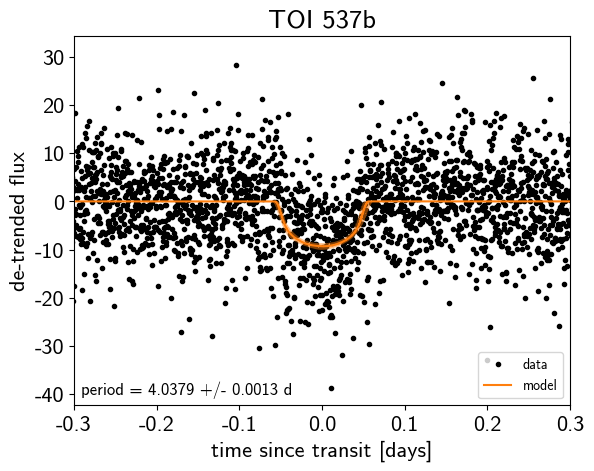

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

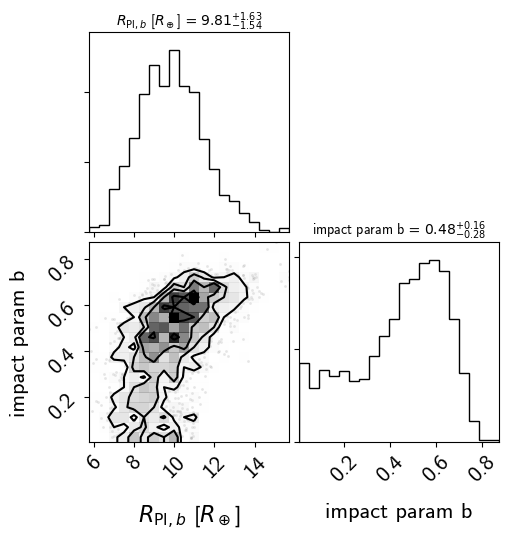

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

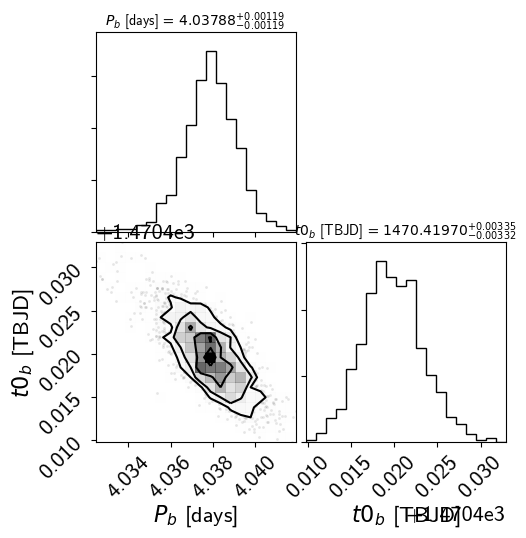

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

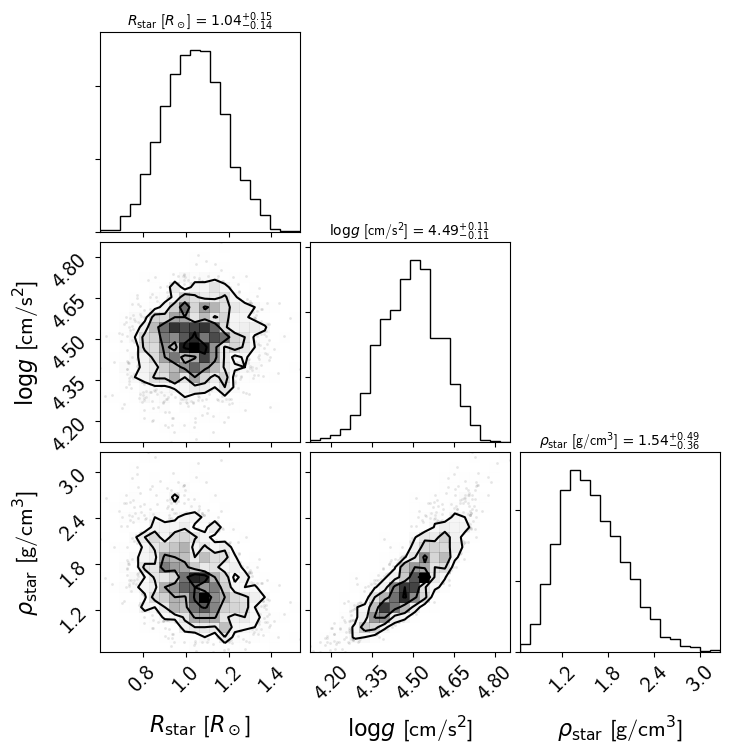

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3